# Final Project: VIX Futures Forecasting

11/26/2018<br>

Vinit Nair <br>
Preethi Ranganathan <br>
Benjamin Richman <br>
Amrita Sharma <br>
Tyler Young<br>

# Load Packages and Data

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm # Time Series Analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import copy
import matplotlib.pylab as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS, yule_walker
from statsmodels.tools.tools import add_constant, Bunch
from statsmodels.tsa._bds import bds
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.tsatools import lagmat, lagmat2ds, add_trend
from statsmodels.tsa.api import VAR
from johansen_test import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.vecm import VECM
from pandas import Series
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15,8
import warnings
warnings.filterwarnings('ignore')

In [2]:
vix = pd.read_csv('vix_data.csv', header =0, index_col = 0)

# Data Exploration

In [3]:
vix.describe()

SPY      RealVol          VIX      VIXCM30      VIXCM60  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000   
mean    132.905896    11.228967    19.586290    20.737151    21.419516   
std      41.630454     8.782778     9.433398     7.751411     6.942745   
min      58.030194     1.725931     9.890000    11.763684    12.900000   
25%     102.141627     6.420053    13.455000    15.270175    16.291053   
50%     118.316563     8.551970    16.670000    18.522917    19.500000   
75%     170.156606    12.769802    22.535000    24.030250    24.680550   
max     221.520000   110.821685    80.860000    62.706364    54.465500   

           VIXCM90     VIXCM120    VIXCM150  
count  2943.000000  2915.000000  509.000000  
mean     21.851063    22.277360   17.815324  
std       6.461391     6.149277    4.051598  
min      13.569474    14.047656   14.298125  
25%      16.963577    17.662237   15.432500  
50%      20.193421    20.660526   16.255079  
75%      25.076158    25.684722   18.905000  
max      48.518947    45.061053   37.655000

In [4]:
nulls120 = str(vix['VIXCM120'].isnull().sum())
print('The VIXCM120 column has ' + nulls120 +' null values.')
nulls150 = str(vix['VIXCM150'].isnull().sum())
print('The VIXCM150 column has ' + nulls150 +' null values.')

The VIXCM120 column has 28 null values.
The VIXCM150 column has 2434 null values.


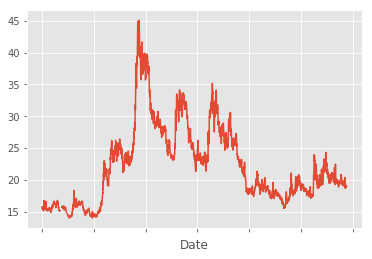

In [5]:
vix['VIXCM120'].plot();

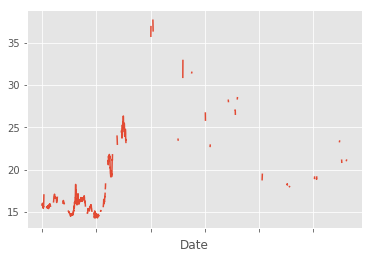

In [6]:
vix['VIXCM150'].plot();

In order to handle the null values in our dataset, chose to fill the VIXCM120 and VIXCM150 columns through the interpolate method, instead of forward or backward fill.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html

In [7]:
vix['VIXCM120']=vix['VIXCM120'].interpolate()
vix['VIXCM150']=vix['VIXCM150'].interpolate()

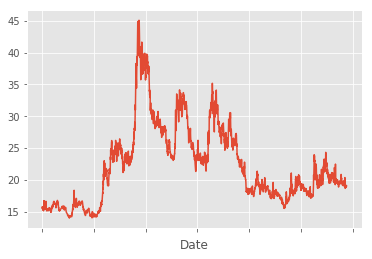

In [10]:
vix['VIXCM120'].plot()

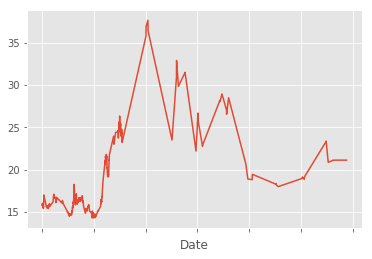

In [8]:
vix['VIXCM150'].plot()

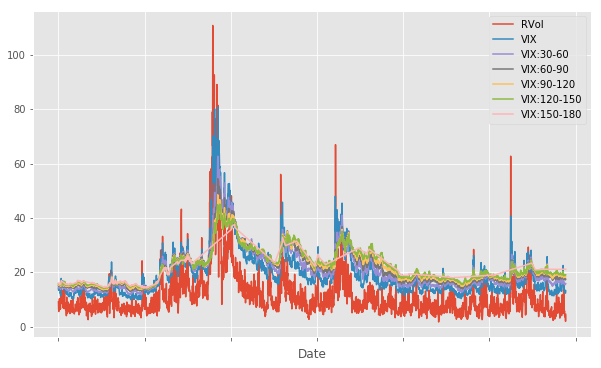

In [9]:
plt.figure(figsize=(10, 6))
vix.RealVol.plot(label='RVol')
vix.VIX.plot(label='VIX')
vix.VIXCM30.plot(label='VIX:30-60')
vix.VIXCM60.plot(label='VIX:60-90')
vix.VIXCM90.plot(label='VIX:90-120')
vix.VIXCM120.plot(label='VIX:120-150')
vix.VIXCM150.plot(label='VIX:150-180')
plt.legend();

Plot of VIX Variables

Since volatility indices are based on returns rather than raw prices we use returns in our models.

In [12]:
vix['SPY_ret'] = vix['SPY'].pct_change()

In [13]:
vix.corr()

SPY   RealVol       VIX   VIXCM30   VIXCM60   VIXCM90  \
SPY       1.000000 -0.370416 -0.448691 -0.474916 -0.478567 -0.470011   
RealVol  -0.370416  1.000000  0.862610  0.732905  0.669239  0.624888   
VIX      -0.448691  0.862610  1.000000  0.949276  0.904740  0.869575   
VIXCM30  -0.474916  0.732905  0.949276  1.000000  0.988666  0.970015   
VIXCM60  -0.478567  0.669239  0.904740  0.988666  1.000000  0.993938   
VIXCM90  -0.470011  0.624888  0.869575  0.970015  0.993938  1.000000   
VIXCM120 -0.455977  0.589693  0.839492  0.950190  0.982756  0.996061   
VIXCM150 -0.408777  0.490956  0.722753  0.853157  0.906139  0.932606   
SPY_ret   0.019941 -0.137838 -0.128789 -0.063839 -0.046847 -0.038479   

          VIXCM120  VIXCM150   SPY_ret  
SPY      -0.455977 -0.408777  0.019941  
RealVol   0.589693  0.490956 -0.137838  
VIX       0.839492  0.722753 -0.128789  
VIXCM30   0.950190  0.853157 -0.063839  
VIXCM60   0.982756  0.906139 -0.046847  
VIXCM90   0.996061  0.932606 -0.038479  
VIXCM120  1.000000  0.943444 -0.033899  
VIXCM150  0.943444  1.000000 -0.008257  
SPY_ret  -0.033899 -0.008257  1.000000

# Time Series Analysis

### Check Stationarity of the series before multivariate analysis

In [17]:
def run_ad_fuller(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print('\nWe fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary')
    else:
        print('\nWe reject the Null Hypothesis (H0) -- the time series is stationary')

In [18]:
## Check stationarity using ad-fuller
colnames = ['SPY_ret', 'RealVol', 'VIX', 'VIXCM30', 'VIXCM60', 'VIXCM90', 'VIXCM120', 'VIXCM150']
for i in colnames:
    print('Test for', i)
    run_ad_fuller(vix_subset[i])
    print('')

Test for SPY_ret
ADF Statistic: -12.501615
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary

Test for RealVol
ADF Statistic: -4.363549
p-value: 0.000344
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary

Test for VIX
ADF Statistic: -3.456160
p-value: 0.009187
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary

Test for VIXCM30
ADF Statistic: -2.647646
p-value: 0.083544
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary

Test for VIXCM60
ADF Statistic: -2.415825
p-value: 0.137320
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary

Test for VIXCM90
AD

In [14]:
## Since some of the raw VIX indices are not stationary, we first difference the data and check for stationarity again.
vix_subset = vix[['SPY_ret', 'RealVol', 'VIX', 'VIXCM30', 'VIXCM60', 'VIXCM90', 'VIXCM120', 'VIXCM150']]
vix_subset['VIX_diff1'] = vix_subset['VIX'].diff(1)
vix_subset['VIXCM30_diff1'] = vix_subset['VIXCM30'].diff(1)
vix_subset['VIXCM60_diff1'] = vix_subset['VIXCM60'].diff(1)
vix_subset['VIXCM90_diff1'] = vix_subset['VIXCM90'].diff(1)
vix_subset['VIXCM120_diff1'] = vix_subset['VIXCM120'].diff(1)
vix_subset['VIXCM150_diff1'] = vix_subset['VIXCM150'].diff(1)
vix_subset.dropna(inplace=True)
vix_subset.head(3)

SPY_ret   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                    
3/24/2005  0.001196  6.457921  13.42  14.225263  14.894773  15.242500   
3/28/2005  0.001451  5.578653  13.75  14.398649  14.993636  15.320909   
3/29/2005 -0.006649  9.290422  14.49  14.931667  15.219773  15.458409   

            VIXCM120   VIXCM150  VIX_diff1  VIXCM30_diff1  VIXCM60_diff1  \
Date                                                                       
3/24/2005  15.524375  15.768125      -0.64      -0.280891      -0.171136   
3/28/2005  15.586250  15.820625       0.33       0.173385       0.098864   
3/29/2005  15.667813  15.864688       0.74       0.533018       0.226136   

           VIXCM90_diff1  VIXCM120_diff1  VIXCM150_diff1  
Date                                                      
3/24/2005      -0.212045       -0.215000       -0.186875  
3/28/2005       0.078409        0.061875        0.052500  
3/29/2005       0.137500        0.081563        0.044063

### Check for Causality

In [0]:
## Customized granger causality function to mute print statements

def grangercausalitytests(x, maxlag, addconst=True, verbose=True):

    x = np.asarray(x)

    if x.shape[0] <= 3 * maxlag + int(addconst):
        raise ValueError("Insufficient observations. Maximum allowable "
                         "lag is {0}".format(int((x.shape[0] - int(addconst)) /
                                                 3) - 1))

    resli = {}

    for mlg in range(1, maxlag + 1):
        result = {}
        mxlg = mlg

        # create lagmat of both time series
        dta = lagmat2ds(x, mxlg, trim='both', dropex=1)

        #add constant
        if addconst:
            dtaown = add_constant(dta[:, 1:(mxlg + 1)], prepend=False)
            dtajoint = add_constant(dta[:, 1:], prepend=False)
        else:
            raise NotImplementedError('Not Implemented')

        # Run ols on both models without and with lags of second variable
        res2down = OLS(dta[:, 0], dtaown).fit()
        res2djoint = OLS(dta[:, 0], dtajoint).fit()

        #print results
        #for ssr based tests see:
        #http://support.sas.com/rnd/app/examples/ets/granger/index.htm
        #the other tests are made-up

        # Granger Causality test using ssr (F statistic)
        fgc1 = ((res2down.ssr - res2djoint.ssr) /
                res2djoint.ssr / mxlg * res2djoint.df_resid)
        result['ssr_ftest'] = (fgc1,
                               stats.f.sf(fgc1, mxlg, res2djoint.df_resid),
                               res2djoint.df_resid, mxlg)

        # Granger Causality test using ssr (ch2 statistic)
        fgc2 = res2down.nobs * (res2down.ssr - res2djoint.ssr) / res2djoint.ssr
        result['ssr_chi2test'] = (fgc2, stats.chi2.sf(fgc2, mxlg), mxlg)

        #likelihood ratio test pvalue:
        lr = -2 * (res2down.llf - res2djoint.llf)
        result['lrtest'] = (lr, stats.chi2.sf(lr, mxlg), mxlg)

        # F test that all lag coefficients of exog are zero
        rconstr = np.column_stack((np.zeros((mxlg, mxlg)),
                                   np.eye(mxlg, mxlg),
                                   np.zeros((mxlg, 1))))
        ftres = res2djoint.f_test(rconstr)
        result['params_ftest'] = (np.squeeze(ftres.fvalue)[()],
                                  np.squeeze(ftres.pvalue)[()],
                                  ftres.df_denom, ftres.df_num)

        resli[mxlg] = (result, [res2down, res2djoint, rconstr])

    return resli

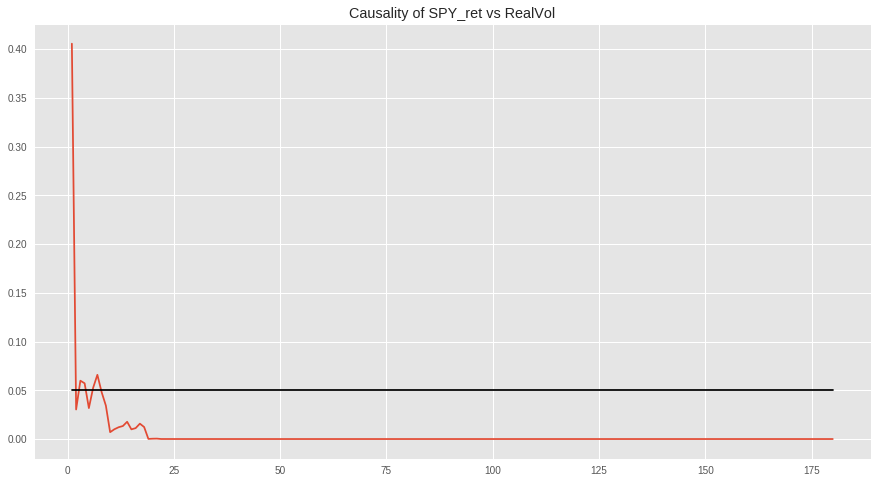

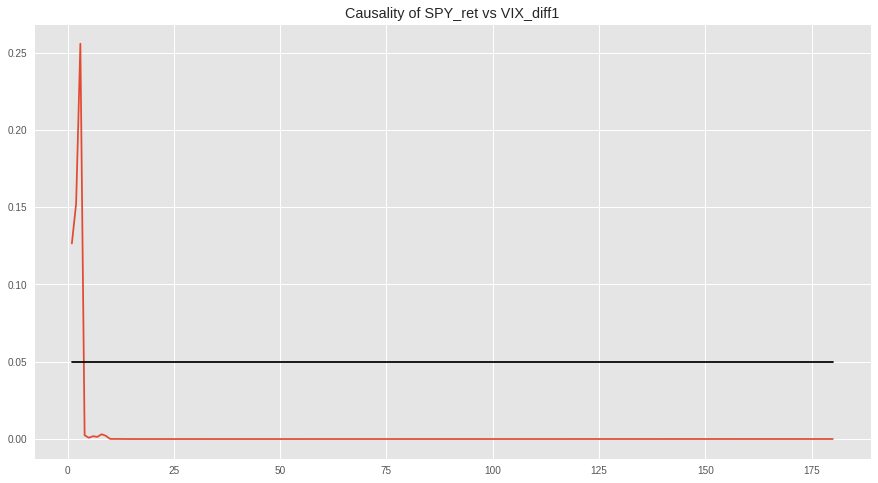

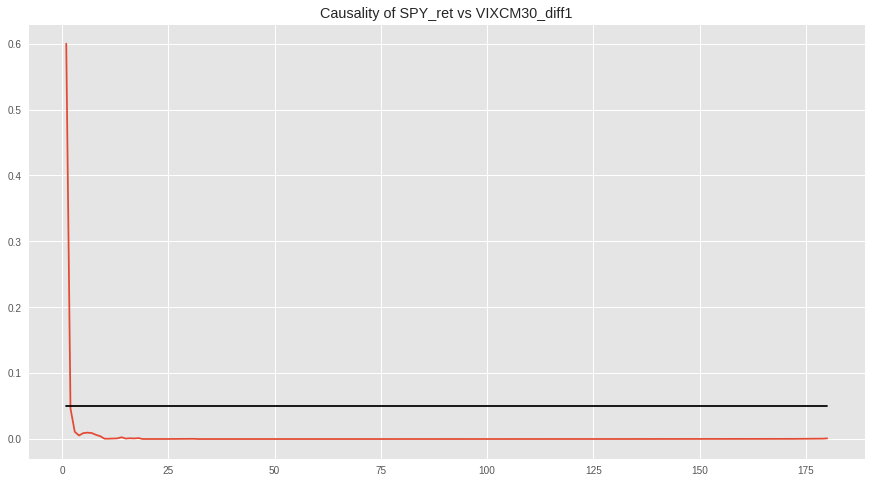

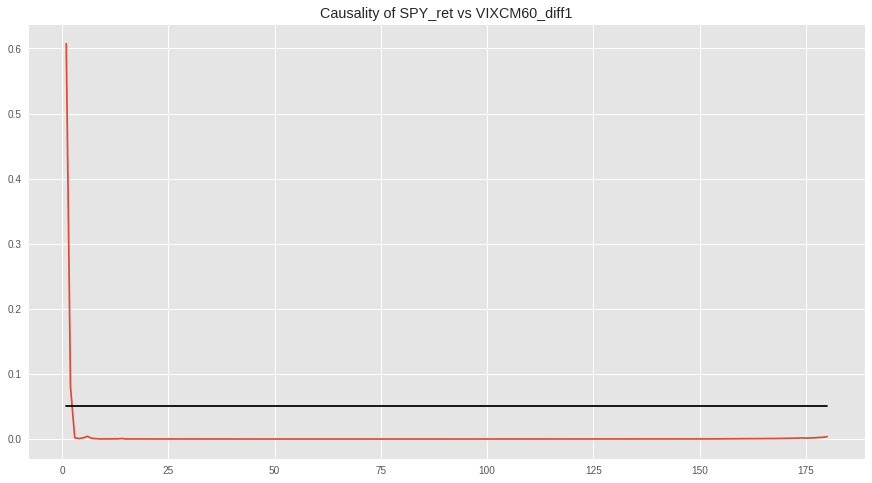

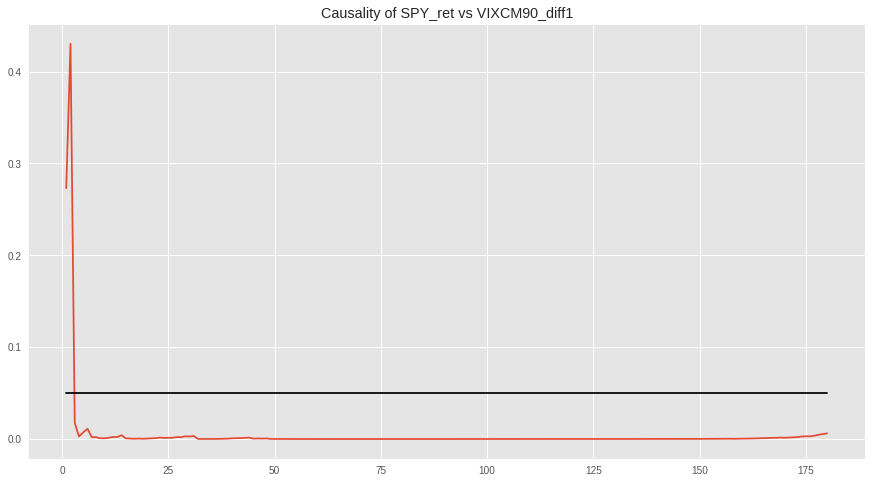

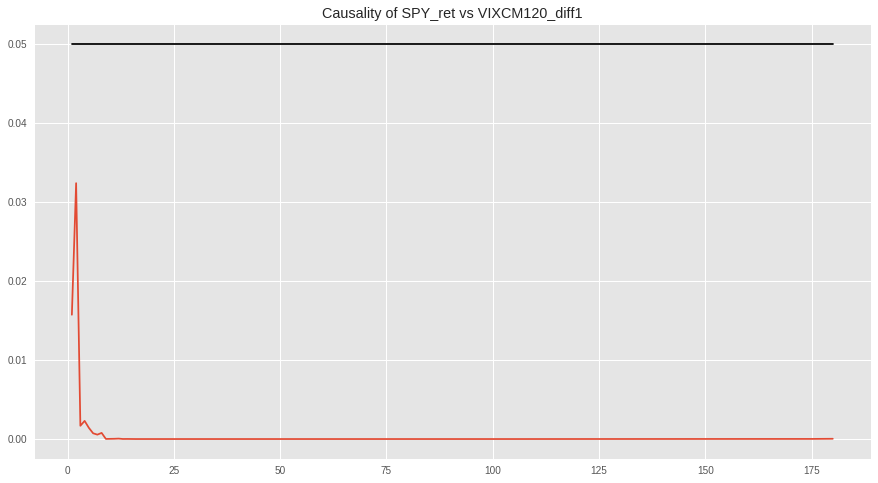

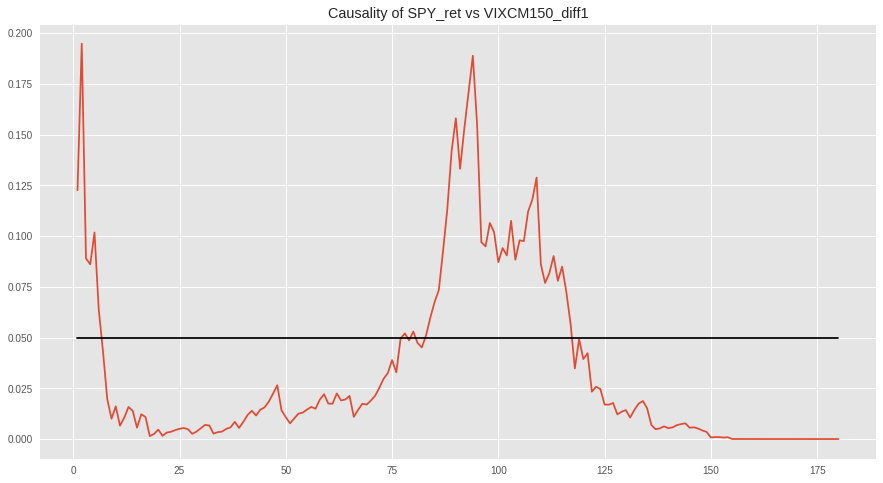

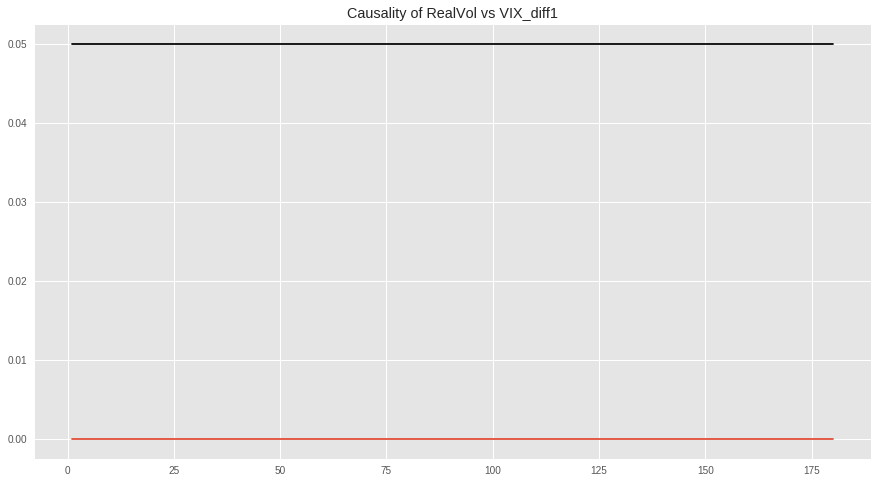

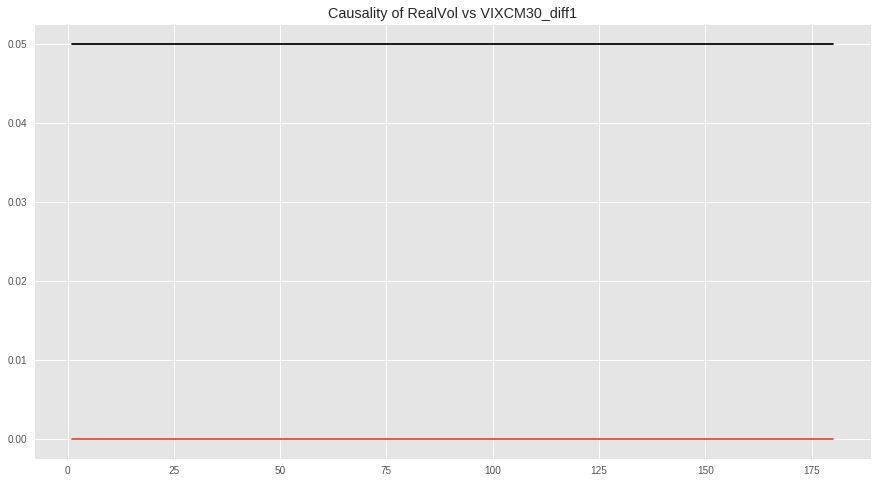

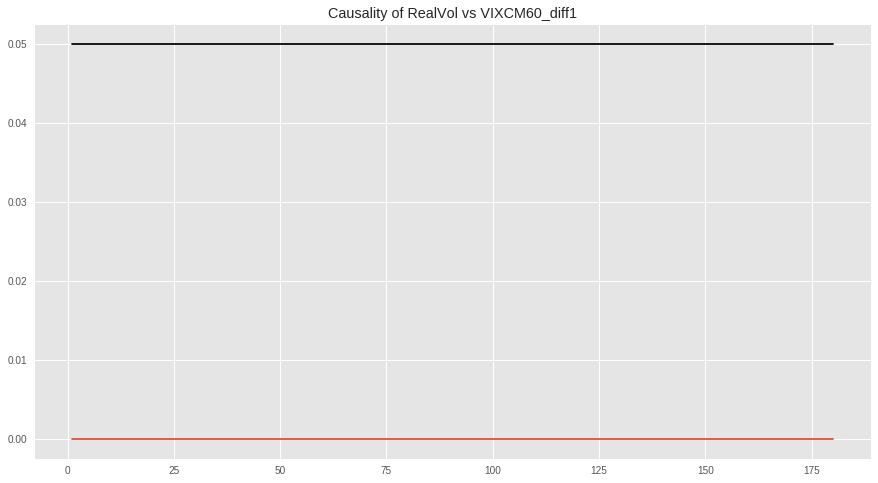

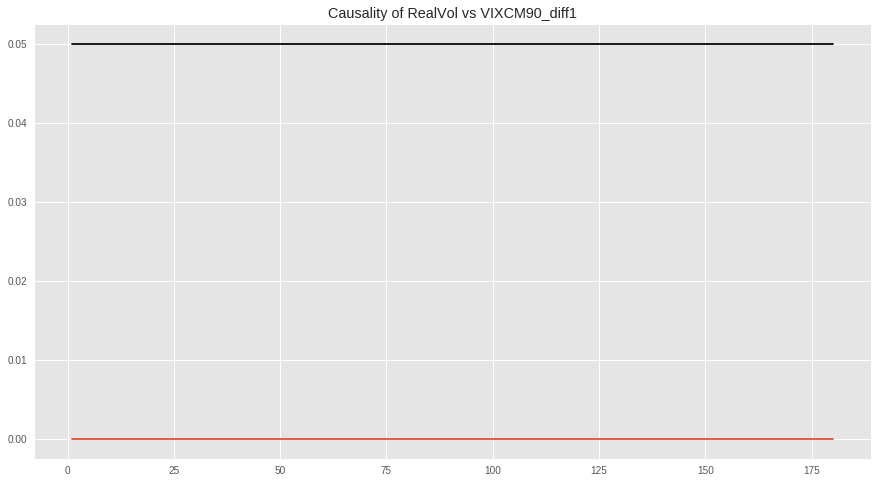

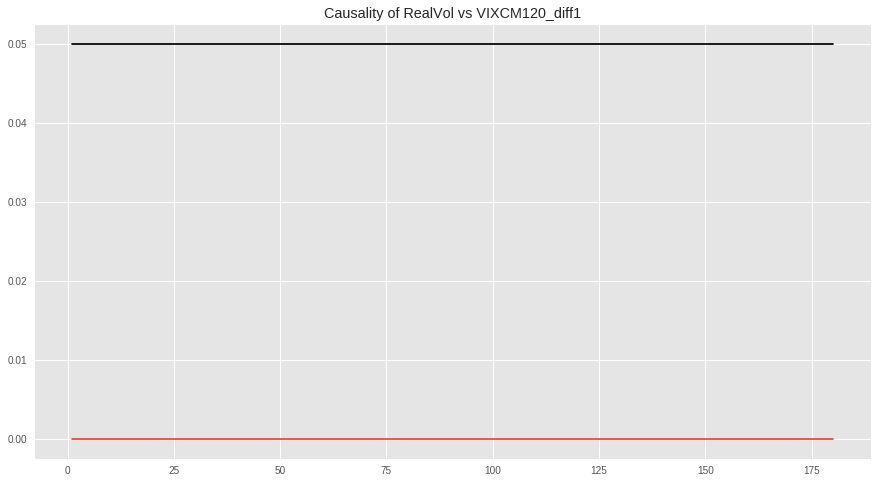

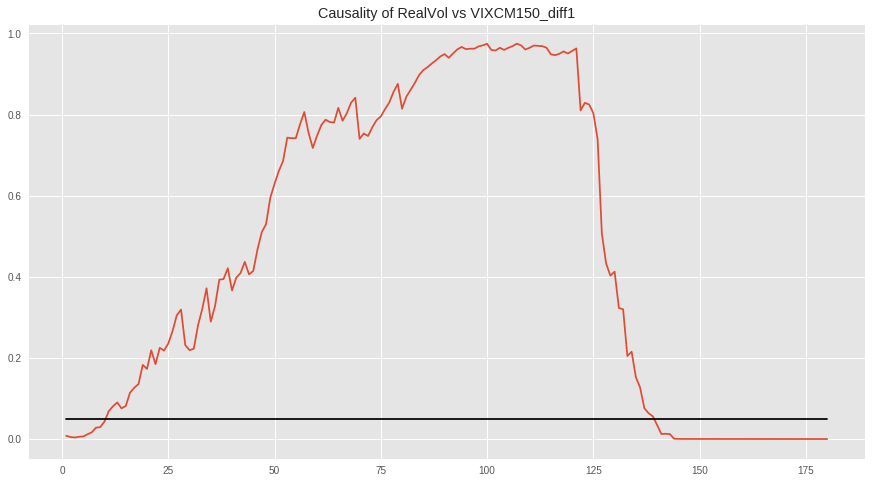

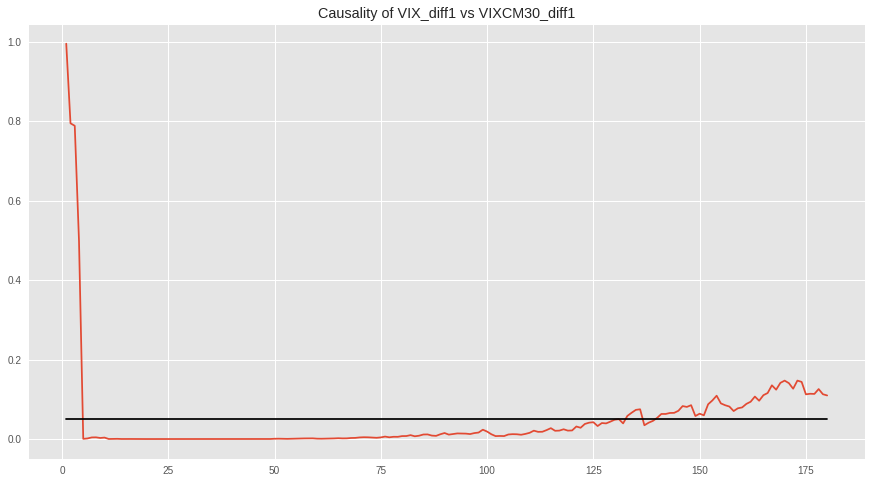

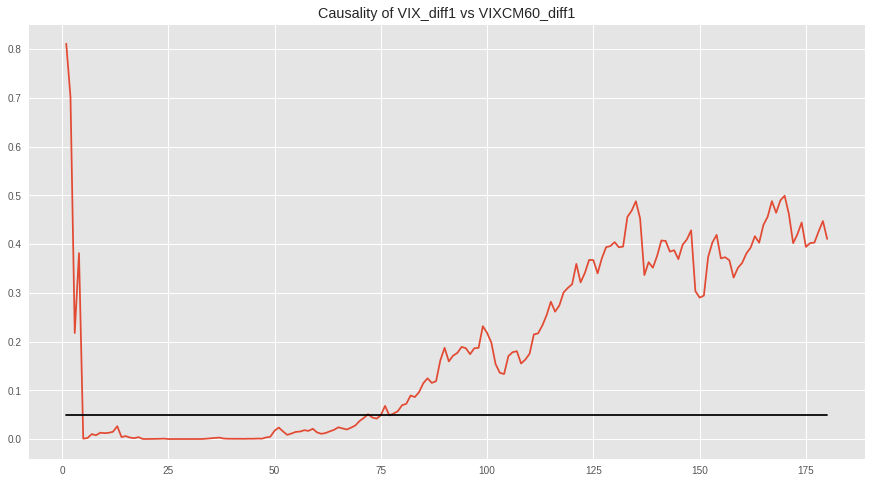

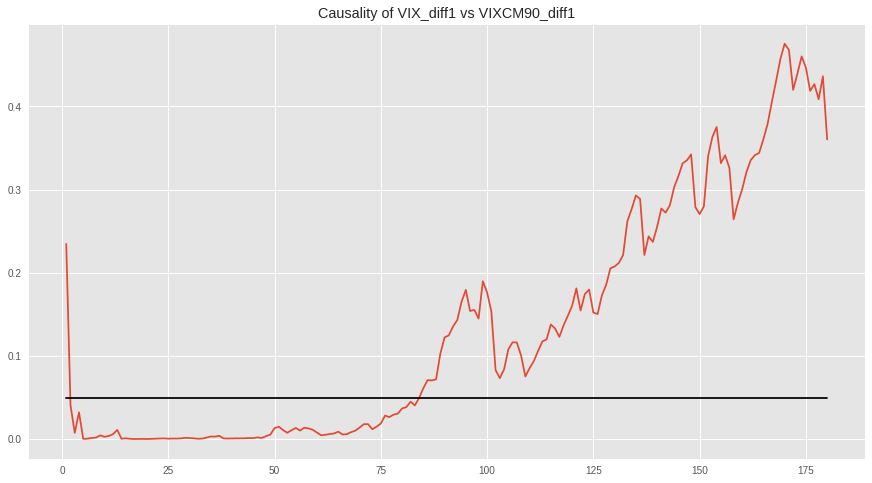

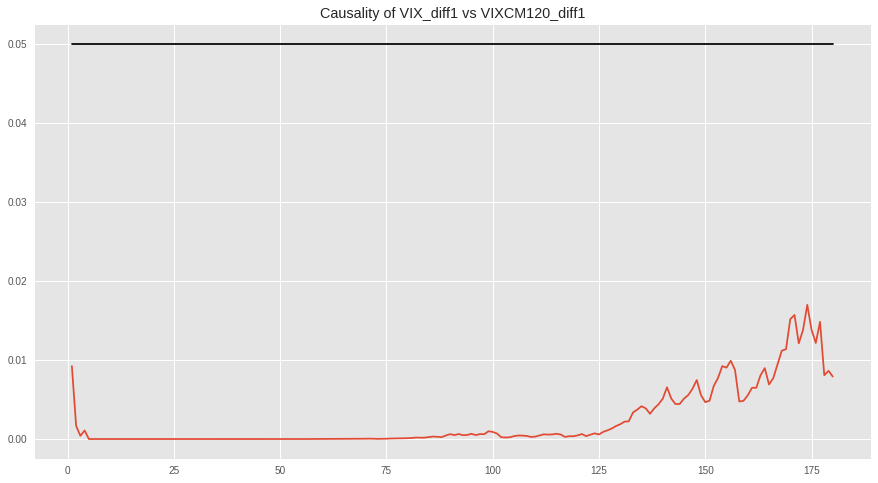

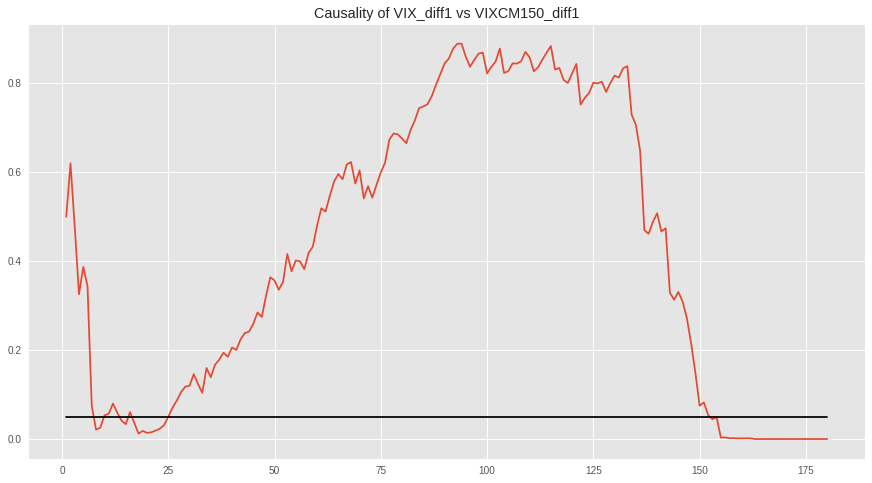

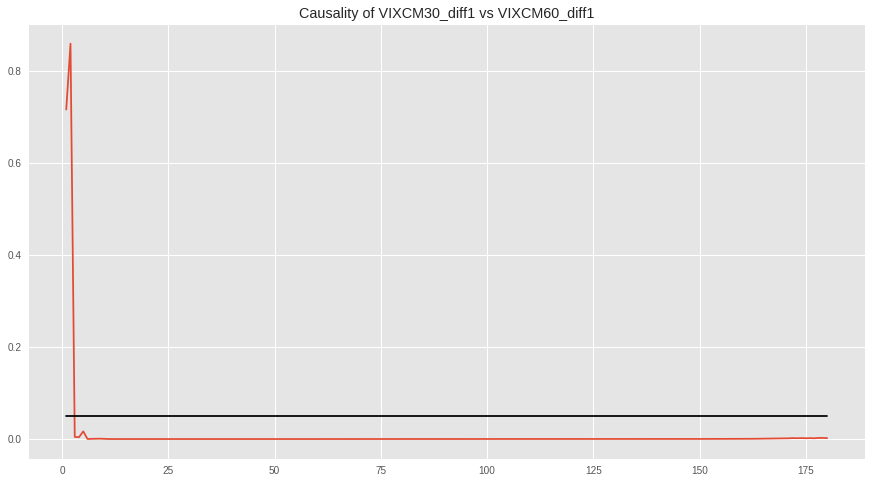

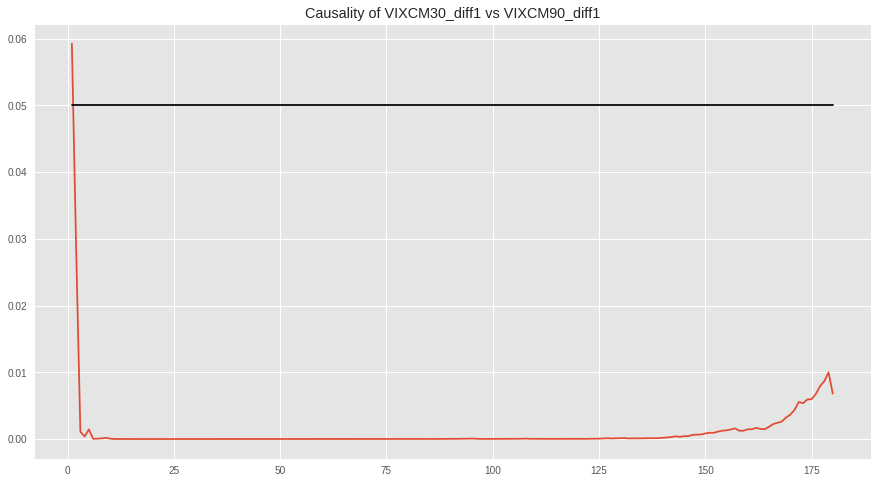

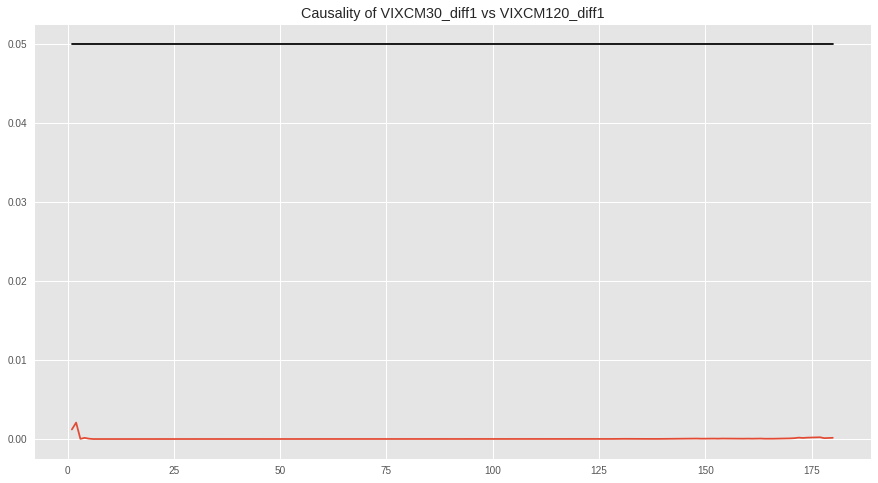

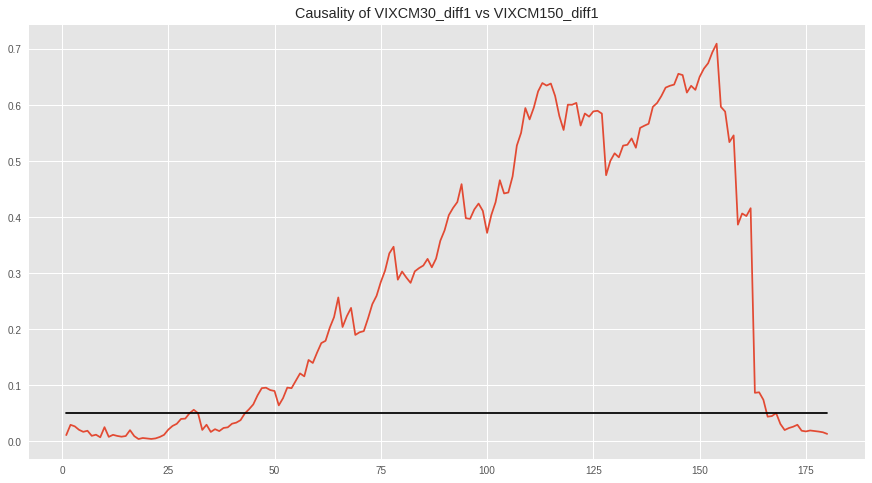

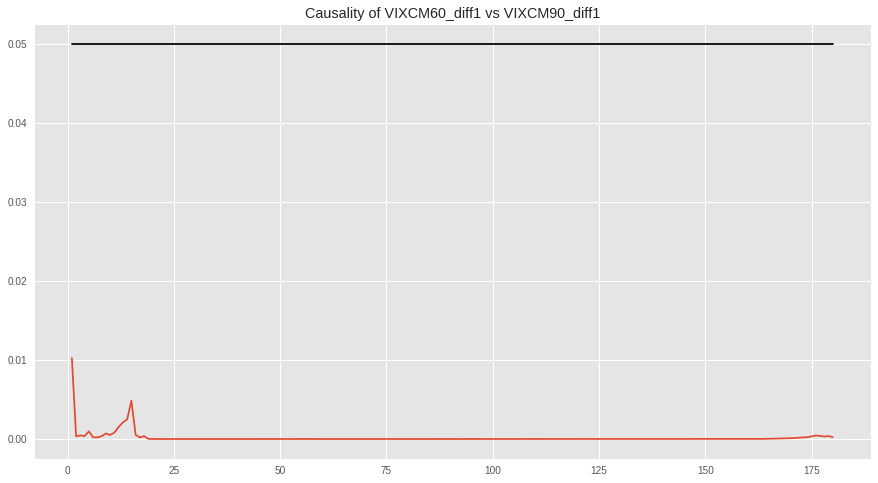

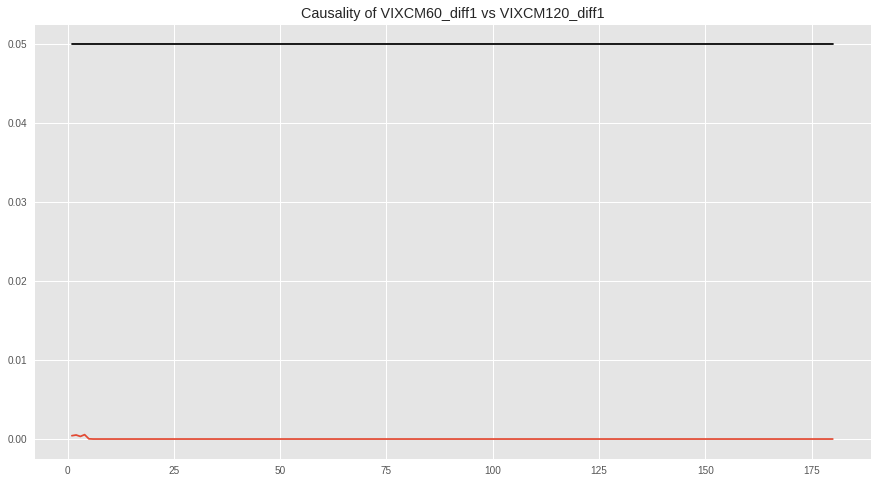

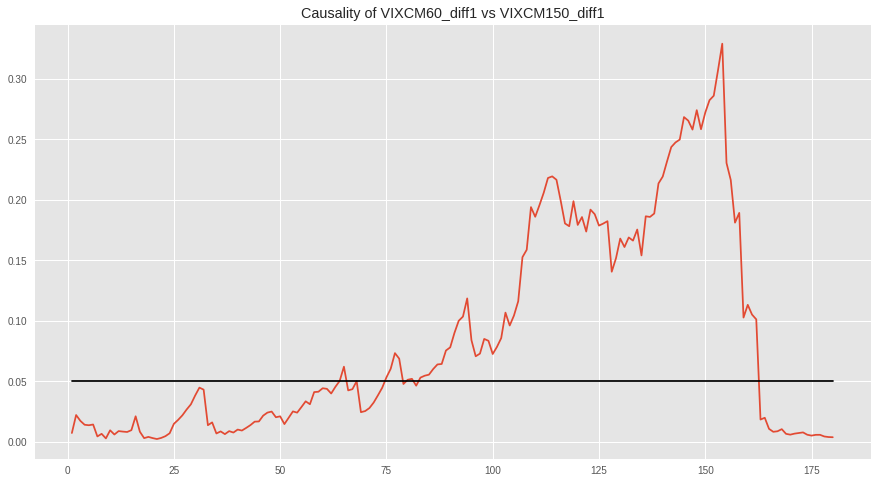

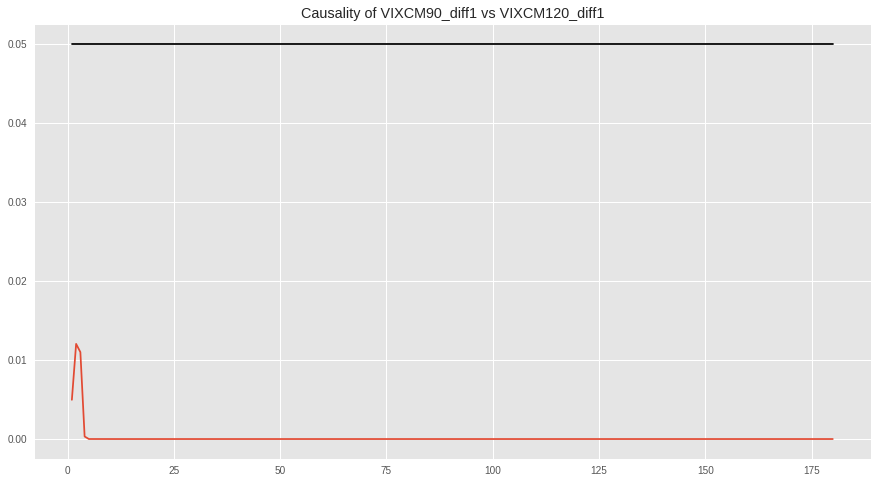

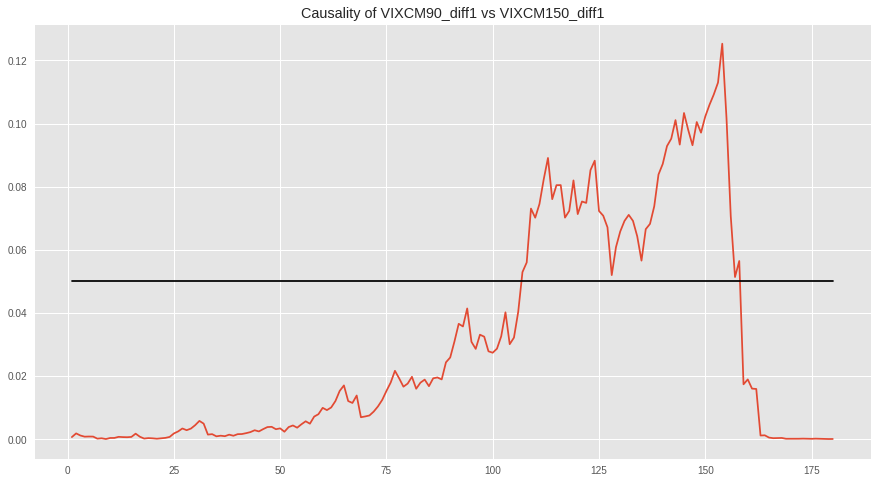

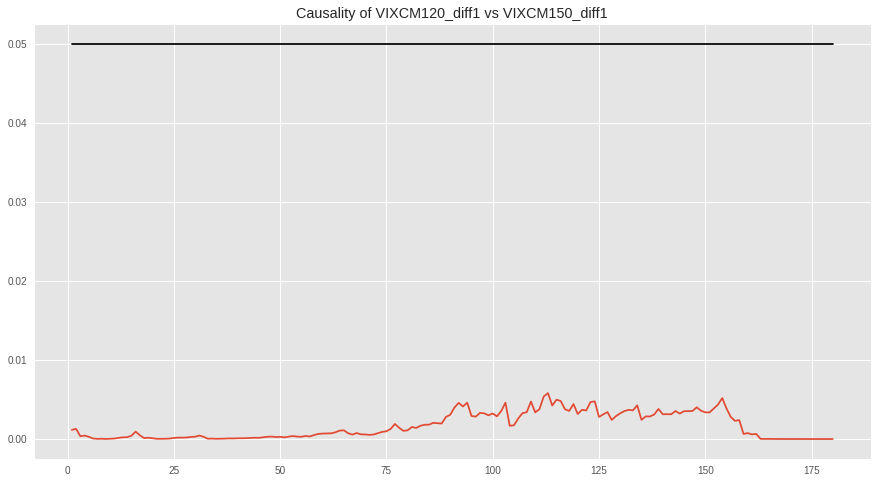

In [0]:
## This function goes through each of the fields in the dataset and checks if the combination is causal
colnames1 = colnames.copy()
for i in colnames:
    for j in colnames1:
        if i != j:
            result = grangercausalitytests(vix_subset[[i, j]], maxlag=180)
            X = []
            Y = []
            for (lag, r) in result.items():
                X += [lag]
                Y += [r[0]['ssr_ftest'][1]]
            plt.plot(X,Y, label='p-value')
            plt.plot([min(X),max(X)],[.05,.05], color='k')
            plt.title("Causality of %s vs %s" % (i, j))
            plt.show()
    colnames1.remove(i)

The plots indicate that the variables are all causal with each other and therefore we can predict the future state of one variable with another.

# Johansen Cointegration test

We run the VAR Model to get an optimal order for the cointegration test.
https://stats.stackexchange.com/questions/21539/what-is-the-correct-procedure-to-choose-the-lag-when-performing-johansen-cointeg

In [19]:
## Divide the data into training and test sets
train,test = train_test_split(vix_subset[colnames], test_size=0.2, shuffle=False)
print('train',len(train))
print('test',len(test))
train.head(5)

train 2353
test 589


SPY_ret   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                    
3/24/2005  0.001196  6.457921  13.42  14.225263  14.894773  15.242500   
3/28/2005  0.001451  5.578653  13.75  14.398649  14.993636  15.320909   
3/29/2005 -0.006649  9.290422  14.49  14.931667  15.219773  15.458409   
3/30/2005  0.014160  7.313855  13.64  14.428571  15.091364  15.398182   
3/31/2005 -0.001862  7.393637  14.02  14.487647  15.097273  15.342727   

            VIXCM120   VIXCM150  
Date                             
3/24/2005  15.524375  15.768125  
3/28/2005  15.586250  15.820625  
3/29/2005  15.667813  15.864688  
3/30/2005  15.600312  15.764375  
3/31/2005  15.540156  15.722969

In [0]:
## Start off with lags=180 to figure out an optimal order
var_model = VAR(train)
aic_bic = var_model.select_order(maxlags=180, trend='nc')

In [0]:
aic_bic.selected_orders

{'aic': 180, 'bic': 2, 'hqic': 7, 'fpe': 39}

Since AIC always returns the maximum no. of lags as the preferred order (we also tried running the VAR model with maxlags as 250!), we decided to continue by using '39' as the number of lags, as suggested by fpe. 

In [0]:
## Cointegration
c = coint_johansen(vix_subset[['SPY_ret', 'RealVol', 'VIX', 'VIXCM30', 'VIXCM60', 'VIXCM90', 'VIXCM120', 'VIXCM150']],1,39)

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 485.9459 169.0618 175.1584 187.1891
r = 1 	 339.8361 133.7852 139.278 150.0778
r = 2 	 213.9746 102.4674 107.3429 116.9829
r = 3 	 146.836 75.1027 79.3422 87.7748
r = 4 	 90.314 51.6492 55.2459 62.5202
r = 5 	 48.406 32.0645 35.0116 41.0815
r = 6 	 14.2809 16.1619 18.3985 23.1485
r = 7 	 6.1535 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 146.1098 52.5858 55.7302 62.1741
r = 1 	 125.8614 46.5583 49.5875 55.8171
r = 2 	 67.1387 40.5244 43.4183 49.4095
r = 3 	 56.5219 34.4202 37.1646 42.8612
r = 4 	 41.908 28.2398 30.8151 36.193
r = 5 	 34.1251 21.8731 24.2522 29.2631
r = 6 	 8.1274 15.0006 17.1481 21.7465
r = 7 	 6.1535 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.03214560e+03 -6.45536097e+02 -6.03251759e+02  1.448

Based on the trace statistics, for most variables we can reject the null hypothesis with more than 99% confidence and thereby these variables are cointegrated. Since the variables are all cointegrated, we use VECM forecasting to predict VIX futures.

# VECM Forecast

In [0]:
## Create training and test sets
train,test = train_test_split(vix_subset[['SPY_ret', 'RealVol', 'VIX', 'VIXCM30', 'VIXCM60', 'VIXCM90', 'VIXCM120', 'VIXCM150']], test_size=0.2, shuffle=False)
print('train',len(train))
print('test',len(test))
train.head(5)

train 2353
test 589


SPY_ret   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                    
3/24/2005  0.001196  6.457921  13.42  14.225263  14.894773  15.242500   
3/28/2005  0.001451  5.578653  13.75  14.398649  14.993636  15.320909   
3/29/2005 -0.006649  9.290422  14.49  14.931667  15.219773  15.458409   
3/30/2005  0.014160  7.313855  13.64  14.428571  15.091364  15.398182   
3/31/2005 -0.001862  7.393637  14.02  14.487647  15.097273  15.342727   

            VIXCM120   VIXCM150  
Date                             
3/24/2005  15.524375  15.768125  
3/28/2005  15.586250  15.820625  
3/29/2005  15.667813  15.864688  
3/30/2005  15.600312  15.764375  
3/31/2005  15.540156  15.722969

In [0]:
def run_ljung_box(X, lags=253):
    (_,p_values) = acorr_ljungbox(X, lags=lags, boxpierce=False)
    print('Ljung-Box Test')
    for n,p_value in enumerate(p_values):
        if p_value < .05:
            print('lag: %3d | p_value: %.4f | still has information' % (n+1, p_value))

In [0]:
## This function comes up with an optimized order for the VECM model based on the lowest RMSEP (Percentage RMSE) 
## across all VIX(VIXCM30, VIXCM60 etc.) variables. It runs the VECM model for lags 1 through 200 to do so.

VECM_opt = {}
for lags in range(1, 201):
    v = VECM(train, deterministic='nc', k_ar_diff=lags)
    print('VECM order', lags)
    f = v.fit()
    for i in range(3, 8):
        run_ljung_box(f.resid[:,i])
    f_hat = f.predict(steps=253)
    tot_rmsep = 0
    for j in range(3, 8):
        p = pd.Series(f_hat[:,j]) 
        a = pd.Series(test.iloc[:,j].values[:253])
        mse = mean_squared_error(a, p)
        rms = sqrt(mse)
        avg = np.mean(a)
        rmsep = rms/avg
        tot_rmsep = tot_rmsep + rmsep
    avg_rmsep = tot_rmsep/5.0
    VECM_opt[lags] = avg_rmsep

VECM order 1
Ljung-Box Test
lag:   5 | p_value: 0.0017 | still has information
lag:   6 | p_value: 0.0026 | still has information
lag:   7 | p_value: 0.0035 | still has information
lag:   8 | p_value: 0.0066 | still has information
lag:   9 | p_value: 0.0113 | still has information
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0001 | still has information
lag:  12 | p_value: 0.0001 | still has information
lag:  13 | p_value: 0.0002 | still has information
lag:  14 | p_value: 0.0000 | still has information
lag:  15 | p_value: 0.0001 | still has information
lag:  16 | p_value: 0.0000 | still has information
lag:  17 | p_value: 0.0000 | still has information
lag:  18 | p_value: 0.0000 | still has information
lag:  19 | p_value: 0.0000 | still has information
lag:  20 | p_value: 0.0000 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0000 | still has information
lag:  23 | p_value: 0.0000 | still has information
lag

In [0]:
print("Lowest RMSEP %f is for order %i" % (VECM_opt[min(VECM_opt, key=VECM_opt.get)], min(VECM_opt, key=VECM_opt.get)))

Lowest RMSEP 0.053503 is for order 113


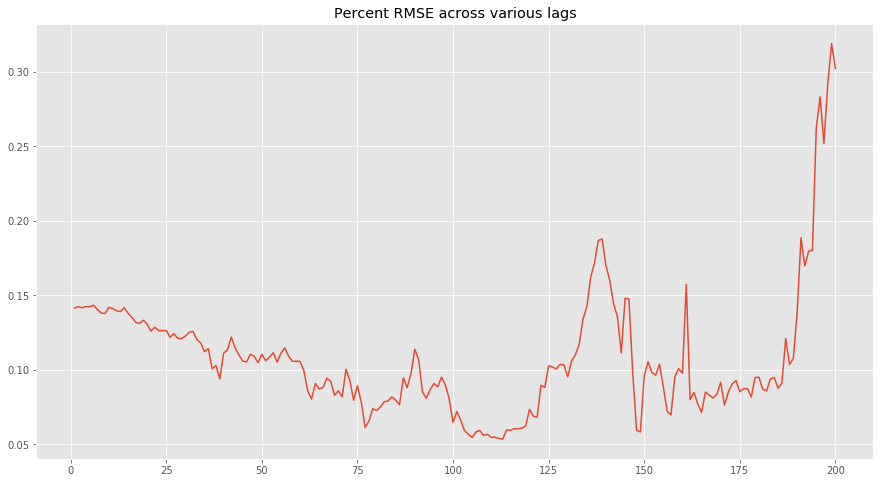

In [0]:
pd.DataFrame.from_dict(VECM_opt, orient='index').plot(legend=False)
plt.title('Percent RMSE across various lags');

In [0]:
## Run VECM with the optimal order found above
v = VECM(train, deterministic='nc', k_ar_diff=113)
f = v.fit()
print(f.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation SPY_ret
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.SPY_ret       -1.4179      0.169     -8.383      0.000      -1.749      -1.086
L1.RealVol       -0.0010      0.000     -5.513      0.000      -0.001      -0.001
L1.VIX            0.0032      0.000      8.723      0.000       0.002       0.004
L1.VIXCM30       -0.0080      0.002     -4.685      0.000      -0.011      -0.005
L1.VIXCM60        0.0167      0.005      3.331      0.001       0.007       0.026
L1.VIXCM90       -0.0125      0.006     -1.923      0.055      -0.025       0.000
L1.VIXCM120       0.0005      0.003      0.157      0.875      -0.006       0.007
L1.VIXCM150      -0.0018      0.002     -0.891      0.373      -0.006       0.002
L2.SPY_ret       -1.4750      0.175     -8.406      0.000      -1.819      -1.131
L2.RealVol 

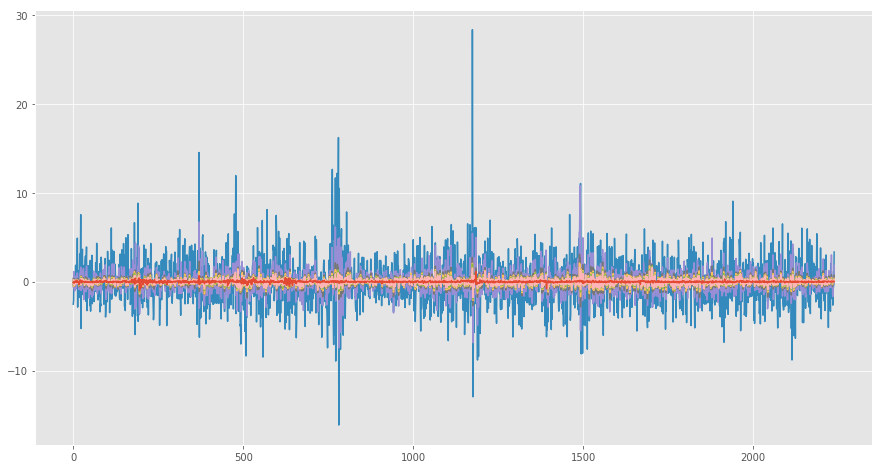

In [0]:
plt.plot(f.resid);

# Ljung -Box test

In [0]:
for i in range(3, 8):
    run_ljung_box(f.resid[:,i])

Ljung-Box Test
Ljung-Box Test
Ljung-Box Test
Ljung-Box Test
Ljung-Box Test


### In-sample prediction

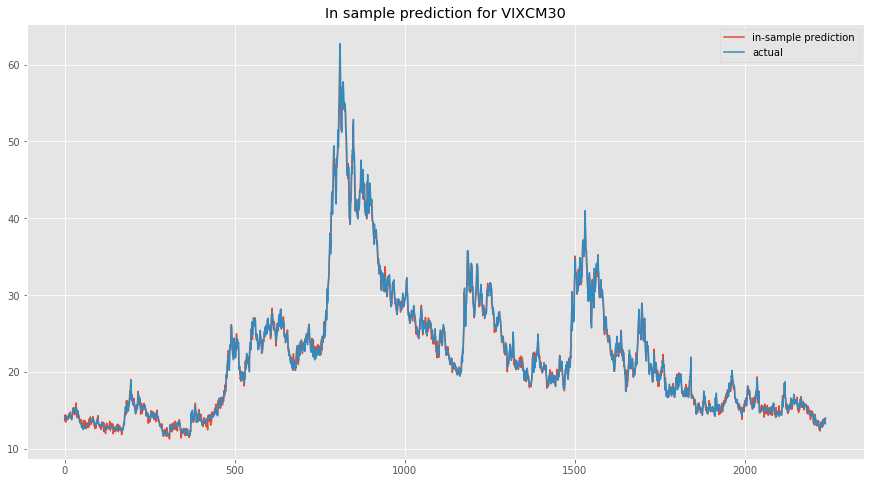

In [0]:
pd.Series(f.fittedvalues[:,3]).plot(label='in-sample prediction')
pd.Series(train['VIXCM30'][113:].values).plot(label='actual')
plt.title('In sample prediction for VIXCM30')
plt.legend()
plt.show();

## Rolling Forecast

We have used an expanding window forecast below, where the window is expanded by adding predicted values to the training set. This allows us to predict farther ahead.

In [0]:
import copy

history = copy.deepcopy(train)
ACTUAL = pd.DataFrame(columns=test.columns)
PRED = pd.DataFrame(columns=test.columns)
for i in range(len(test)):
    r_t = pd.DataFrame(test.head(i+1).tail(1), columns=test.columns,
                        index = test.head(i+1).tail(1).index)
    model = VECM(history, deterministic='nc', k_ar_diff=113)
    r = model.fit()
    ACTUAL = ACTUAL.append(r_t)
    P = r.predict(1)  
    pred = pd.DataFrame(P,columns=test.columns,index = test.head(i+1).tail(1).index)
    PRED = PRED.append(pred)
    history = history.append(pred)    

Populating the interactive namespace from numpy and matplotlib


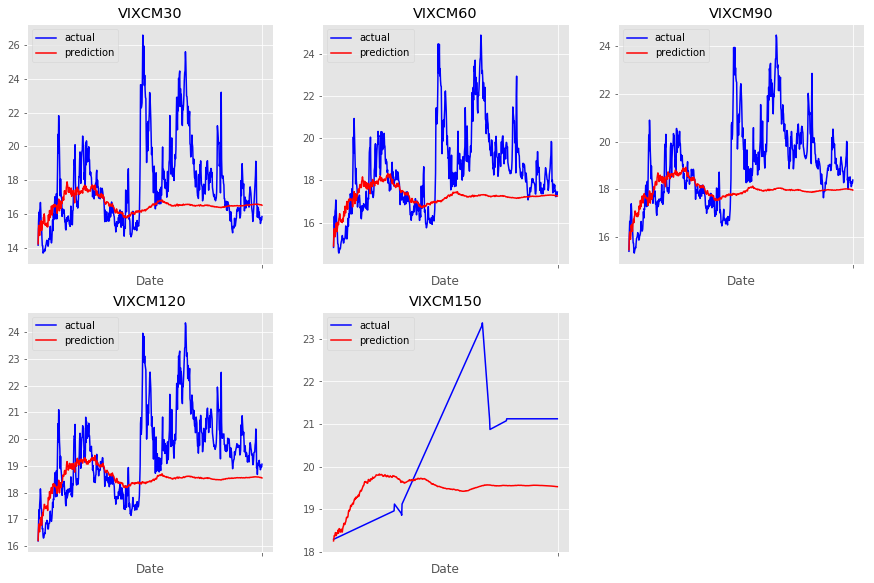

In [0]:
% pylab inline
figure(figsize=(15,15))
for i in range(ACTUAL.shape[1]-3):
    plt.subplot(3,3,i+1)
    plt.title(ACTUAL.columns[i+3])
    plt.plot(ACTUAL.iloc[:,i+3], color='b', label='actual')
    plt.plot(PRED.iloc[:,i+3], color='r',label='prediction')
    plt.xlabel('Date')
    plt.legend()
    xticks('')

While you value predictions, do not match the actual values for the range of each predicted feature. The trends is predicted well through the first 200 predicted days or so except for vix150.

In [0]:
def measure_error(a,p):
    mse = mean_squared_error(a, p)
    rmse = sqrt(mse)
    avg = np.mean(a)
    mape = np.mean(np.abs(a-p))/avg
    rmsep = rmse/avg
    msep = mse/avg
    return mse, rmse, msep, rmsep, mape

In [0]:
for i in range(ACTUAL.shape[1]-3):
    mse, rmse, msep, rmsep, mape = measure_error(ACTUAL.iloc[:,i+3],PRED.iloc[:,i+3])
    print('Rolling forecast of',ACTUAL.columns[i+3],':','\n \t RMSE:',rmse, ',RMSEP:',rmsep,',MAPE:',mape)

Rolling forecast of VIXCM30 : 
 	 RMSE: 2.605838050938364 ,RMSEP: 0.14770194415108848 ,MAPE: 0.09979131110373138
Rolling forecast of VIXCM60 : 
 	 RMSE: 2.1970564294047374 ,RMSEP: 0.11909428604808542 ,MAPE: 0.08521203909600963
Rolling forecast of VIXCM90 : 
 	 RMSE: 1.9359207174196877 ,RMSEP: 0.10190175543478339 ,MAPE: 0.07541294879151882
Rolling forecast of VIXCM120 : 
 	 RMSE: 1.7207720095336811 ,RMSEP: 0.08843744424123824 ,MAPE: 0.06696445834418462
Rolling forecast of VIXCM150 : 
 	 RMSE: 1.6540344419743576 ,RMSEP: 0.080935388877647 ,MAPE: 0.06782900917303705


We have used an expanding window forecast below, where the window is expanded by adding actual values to the training set. This allows us to predict only the next day.

In [0]:
## Create training and test sets
train,test = train_test_split(vix_subset[['SPY_ret', 'RealVol', 'VIX', 'VIXCM30', 'VIXCM60', 'VIXCM90', 'VIXCM120', 'VIXCM150']], test_size=0.2, shuffle=False)
print('train',len(train))
print('test',len(test))
train.head(5)

train 2353
test 589


SPY_ret   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                    
3/24/2005  0.001196  6.457921  13.42  14.225263  14.894773  15.242500   
3/28/2005  0.001451  5.578653  13.75  14.398649  14.993636  15.320909   
3/29/2005 -0.006649  9.290422  14.49  14.931667  15.219773  15.458409   
3/30/2005  0.014160  7.313855  13.64  14.428571  15.091364  15.398182   
3/31/2005 -0.001862  7.393637  14.02  14.487647  15.097273  15.342727   

            VIXCM120   VIXCM150  
Date                             
3/24/2005  15.524375  15.768125  
3/28/2005  15.586250  15.820625  
3/29/2005  15.667813  15.864688  
3/30/2005  15.600312  15.764375  
3/31/2005  15.540156  15.722969

In [0]:
import copy

history = copy.deepcopy(train)
ACTUAL = pd.DataFrame(columns=test.columns)
PRED = pd.DataFrame(columns=test.columns)
for i in range(len(test)):
    r_t = pd.DataFrame(test.head(i+1).tail(1), columns=test.columns,
                        index = test.head(i+1).tail(1).index)
    model = VECM(history, deterministic='nc', k_ar_diff=113)
    r = model.fit()
    ACTUAL = ACTUAL.append(r_t)
    P = r.predict(1)  
    pred = pd.DataFrame(P,columns=test.columns,index = test.head(i+1).tail(1).index)
    PRED = PRED.append(pred)
    history = history.append(r_t)    

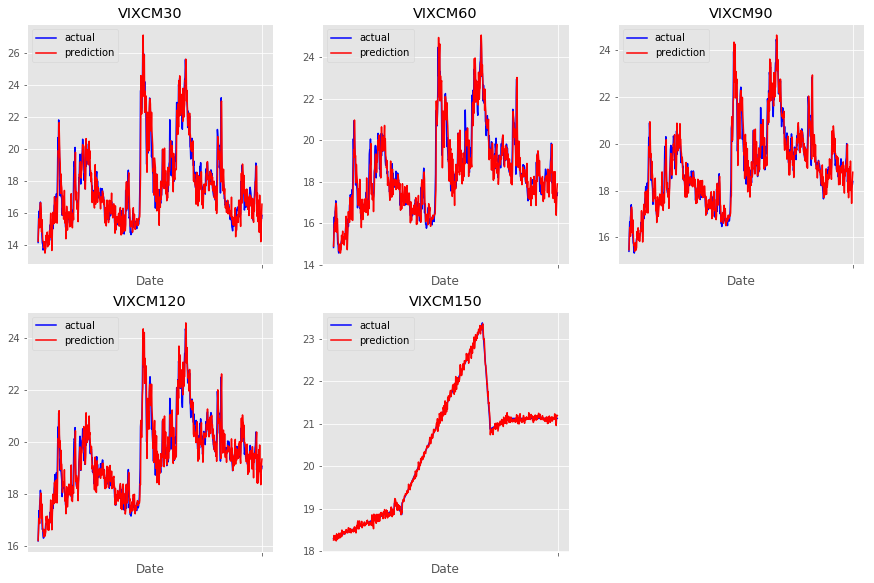

In [0]:
figure(figsize=(15,15))
for i in range(ACTUAL.shape[1]-3):
    plt.subplot(3,3,i+1)
    plt.title(ACTUAL.columns[i+3])
    plt.plot(ACTUAL.iloc[:,i+3], color='b', label='actual')
    plt.plot(PRED.iloc[:,i+3], color='r',label='prediction')
    plt.xlabel('Date')
    plt.legend()
    xticks('')

In [0]:
for i in range(ACTUAL.shape[1]-3):
    mse, rmse, msep, rmsep, mape = measure_error(ACTUAL.iloc[:,i+3],PRED.iloc[:,i+3])
    print('Rolling forecast of',ACTUAL.columns[i+3],':','\n \t RMSE:',rmse, ',RMSEP:',rmsep,',MAPE:',mape)

Rolling forecast of VIXCM30 : 
 	 RMSE: 0.9624341529769889 ,RMSEP: 0.05455189184182717 ,MAPE: 0.0400544020399389
Rolling forecast of VIXCM60 : 
 	 RMSE: 0.7146876389377467 ,RMSEP: 0.03874056804710455 ,MAPE: 0.028390640369452366
Rolling forecast of VIXCM90 : 
 	 RMSE: 0.597053204772802 ,RMSEP: 0.03142730438641308 ,MAPE: 0.02321117402877246
Rolling forecast of VIXCM120 : 
 	 RMSE: 0.5322885249748274 ,RMSEP: 0.02735646354479527 ,MAPE: 0.020275673722798232
Rolling forecast of VIXCM150 : 
 	 RMSE: 0.07117502422704196 ,RMSEP: 0.0034827438401557136 ,MAPE: 0.002765853960081254


# Naive Model

In [20]:
test = test.reset_index()
test.head()

Date   SPY_ret    RealVol    VIX    VIXCM30  VIXCM60    VIXCM90  \
0  7/30/2014  0.000152   8.611443  13.33  14.142105  14.8225  15.394737   
1  7/31/2014 -0.019748  11.349166  16.95  15.452632  15.7850  16.163158   
2   8/1/2014 -0.003056  12.372741  17.03  16.094737  16.2950  16.652632   
3   8/4/2014  0.007221   6.906376  15.12  15.328947  15.7700  16.197368   
4   8/5/2014 -0.009696  12.950394  16.87  16.200000  16.5375  16.839474   

    VIXCM120   VIXCM150  
0  16.200000  18.297891  
1  16.876316  18.302087  
2  17.357895  18.306283  
3  17.028947  18.310478  
4  17.555263  18.314674

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
def measure_error(actual, pred, label=None, show=True):
  
    sq_error = mean_squared_error(actual,pred)
    rmse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    mape = mean_absolute_percentage_error(actual,pred)
    errors = {'RMSE': rmse, 'RMSE_pcent': rmse / avg, 'MSE':sq_error, 'MAPE':mape}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors

To check how effective our models are we 'Naive' forecasted the futures for ~ 500 days (length of the test set) by taking rolling mean of the previous month (21 trading days). 

In [69]:
def naive_forecasting(a,Y):
    actual = a
    a = a.iloc[0:21]
    pred= [0 for x in range(0,21)]
    window = 21
    for i in range(len(actual)-21):
        pred.append(np.mean(a.iloc[i:i+window]))
        a[window+i] = pred[i+21]
        
    actual = actual.tolist()
    plt.plot(pred[22:],color='red', label = 'Prediction')
    plt.plot(actual[22:],color='blue', label = 'Actual')
    plt.title('Naive Forecasting for Out Of Sample %s' %(Y))
    plt.legend()
    plt.show()
    error = measure_error(actual, pred)
                
    return pred

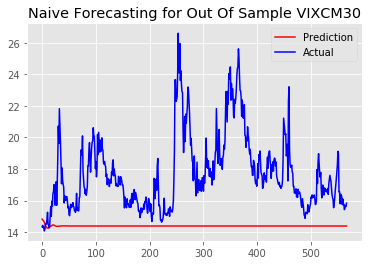

RMSE = 4.909327804708627
RMSE_pcent = 0.2782664336984964
MSE = 24.101499494085232
MAPE = 20.60536909922003


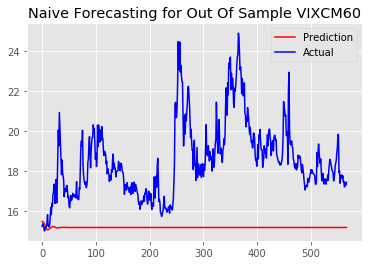

RMSE = 4.772065100192104
RMSE_pcent = 0.25867596229030126
MSE = 22.772605320471477
MAPE = 20.28881297504862


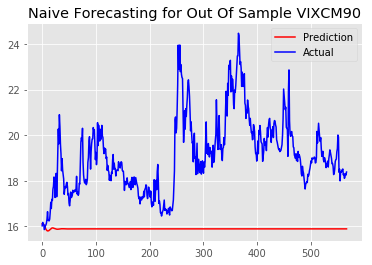

RMSE = 4.6649220153964865
RMSE_pcent = 0.24554917877466756
MSE = 21.761497409730815
MAPE = 19.20898970598826


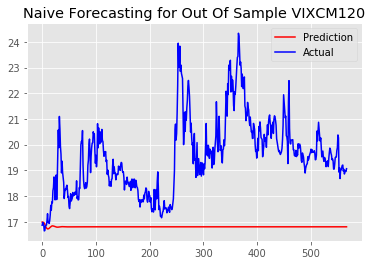

RMSE = 4.427180292599487
RMSE_pcent = 0.22753072929096388
MSE = 19.59992534318128
MAPE = 16.692920039964637


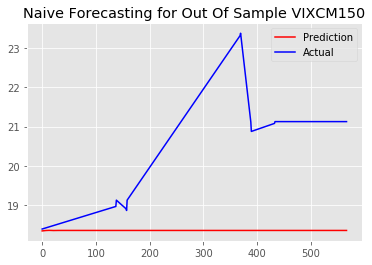

RMSE = 4.277796855060521
RMSE_pcent = 0.20932160976685762
MSE = 18.29954593316569
MAPE = 13.33237119715134


In [70]:
for j in range(4, 9):
    series = test.iloc[:,j]
    Y = test.iloc[:,j].name
    naive_forecasting(series, Y)

In the 'Naive' forecasting method used below, we predict values for the next day by using rolling mean of the last 21 days.

In [61]:
def naive_forecasting_actual(a,Y):
    pred= [0 for x in range(0,21)]
    window = 21
    for i in range(len(a)-21):
        pred.append(np.mean(a.iloc[i:i+window]))
        #a[window+i] = pred[i]
    a = a.tolist()
    plt.plot(pred[22:],color='red', label = 'Prediction')
    plt.plot(a[22:],color='blue', label = 'Actual')
    plt.title('Naive Forecasting for Out Of Sample %s' %(Y))
    plt.legend()
    plt.show()
    error = measure_error(a, pred)
    
    return pred

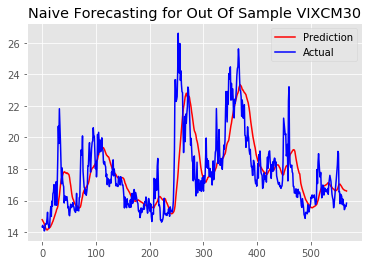

RMSE = 3.249538844788804
RMSE_pcent = 0.18418765694090367
MSE = 10.559502703791356
MAPE = 9.690090798241838


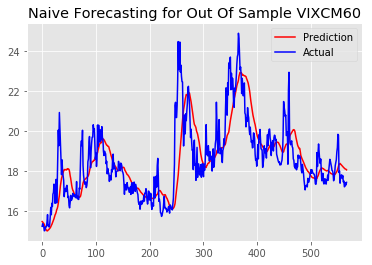

RMSE = 3.16925002456742
RMSE_pcent = 0.17179329758316503
MSE = 10.044145718220593
MAPE = 7.878754712221192


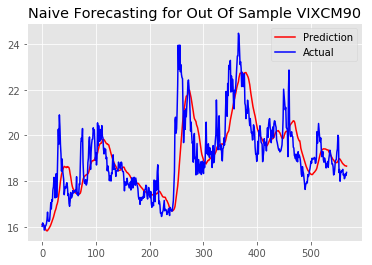

RMSE = 3.2139844414939973
RMSE_pcent = 0.1691756555841017
MSE = 10.329695990165481
MAPE = 7.244803871107178


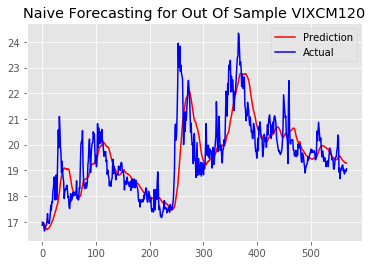

RMSE = 3.3268912786705793
RMSE_pcent = 0.1709824197069683
MSE = 11.068205580094363
MAPE = 6.586613364993423


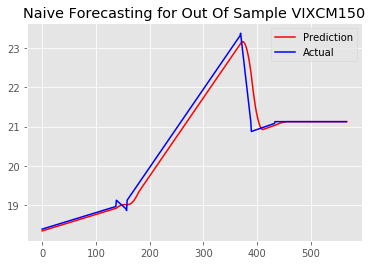

RMSE = 3.4715267074043856
RMSE_pcent = 0.16986911332241003
MSE = 12.051497680221935
MAPE = 4.229582757711397


In [62]:
for j in range(4, 9):
    series = test.iloc[:,j]
    Y = test.iloc[:,j].name
    naive_forecasting_actual(series, Y)

# Volatility Forecasting using RNNs

## VIXCM30 Forecast: Data Prep and Modeling

Select only variables to be used in forecasting VIXCM30

In [0]:
df1 = vix[['SPY','RealVol','VIX','VIXCM30']]
df1[:5]

SPY   RealVol    VIX    VIXCM30
Date                                            
3/23/2005  92.578594  9.120305  14.06  14.506154
3/24/2005  92.689358  6.457921  13.42  14.225263
3/28/2005  92.823878  5.578653  13.75  14.398649
3/29/2005  92.206709  9.290422  14.49  14.931667
3/30/2005  93.512316  7.313855  13.64  14.428571

In [0]:
## Create training and test sets
train,test = train_test_split(df1, test_size=0.2, shuffle=False)
print('train: ',len(train))
print('test : ',len(test))

train:  2354
test :  589


Create/Store average and standard deviation of VIXCM30 from training data. To be used to reverse normalization of testing data for prediction.

In [0]:
muVIX30 = train['VIXCM30'].mean()
print(muVIX30)
sdVIX30 = train['VIXCM30'].std()
print(sdVIX30)

21.51146019482583
8.40785328118895


Function to normalize dataframes for training and testing data by subtracting average and dividing by standard deviation from the training data.

In [0]:
def normalizer(dataframe_train, dataframe_test):
    dataframe_train1 = dataframe_train
    dataframe_test1 = dataframe_test
    n_cols = len(dataframe_train.columns)
    for i in range(n_cols):
        mu = dataframe_train1[dataframe_train1.columns[i]].mean()
        sd = dataframe_train1[dataframe_train1.columns[i]].std()
        dataframe_train1[dataframe_train1.columns[i]] = (dataframe_train1[dataframe_train1.columns[i]]-mu)/sd
        
        dataframe_test1[dataframe_test1.columns[i]] = (dataframe_test1[dataframe_test1.columns[i]]-mu)/sd
        
    return dataframe_train1, dataframe_test1

In [0]:
train11, test11 = normalizer(train, test)

In [0]:
train11.head()

SPY   RealVol       VIX   VIXCM30
Date                                             
3/23/2005 -0.886184 -0.293285 -0.627037 -0.833186
3/24/2005 -0.881963 -0.577092 -0.689937 -0.866594
3/28/2005 -0.876837 -0.670821 -0.657504 -0.845972
3/29/2005 -0.900354 -0.275151 -0.584775 -0.782577
3/30/2005 -0.850605 -0.485850 -0.668315 -0.842413

### Define function to shift columns creating lags for series supervised learning

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [0]:
values = train11.values
values = values.astype('float32')
values1 = test11.values
values1 = test11.astype('float32')

# frame as supervised learning
reframed_train = series_to_supervised(values, 1, 1)
reframed_test = series_to_supervised(values1, 1, 1)
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[4,5,6]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4,5,6]], axis=1, inplace=True)
print(reframed_train.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1  -0.886184  -0.293285  -0.627037  -0.833186 -0.866594
2  -0.881963  -0.577092  -0.689937  -0.866594 -0.845972
3  -0.876837  -0.670821  -0.657504  -0.845972 -0.782577
4  -0.900354  -0.275151  -0.584775  -0.782577 -0.842413
5  -0.850605  -0.485850  -0.668315  -0.842413 -0.835387


** The two datasets created (training and testing) have effectively added a shifted the VIXCM30 column. This will allow us to predict/forecast the VIXCM30 for tomorrow based on the SPY, RealVol, VIX, and VIXCM30 from today. (seen above as 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', and 'var4(t-1)', respectively.) **

In [0]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2353, 1, 4) (2353,) (588, 1, 4) (588,)


### Define a LSTM RNN, compile, fit with training data, and validate on testing data.

Train on 2353 samples, validate on 588 samples
Epoch 1/50
 - 2s - loss: 0.7235 - val_loss: 0.3098
Epoch 2/50
 - 0s - loss: 0.6643 - val_loss: 0.2338
Epoch 3/50
 - 0s - loss: 0.6060 - val_loss: 0.1720
Epoch 4/50
 - 0s - loss: 0.5468 - val_loss: 0.1426
Epoch 5/50
 - 0s - loss: 0.4869 - val_loss: 0.1655
Epoch 6/50
 - 0s - loss: 0.4287 - val_loss: 0.2332
Epoch 7/50
 - 0s - loss: 0.3799 - val_loss: 0.3021
Epoch 8/50
 - 0s - loss: 0.3436 - val_loss: 0.3261
Epoch 9/50
 - 0s - loss: 0.3130 - val_loss: 0.3171
Epoch 10/50
 - 0s - loss: 0.2859 - val_loss: 0.2993
Epoch 11/50
 - 0s - loss: 0.2612 - val_loss: 0.2773
Epoch 12/50
 - 0s - loss: 0.2391 - val_loss: 0.2524
Epoch 13/50
 - 0s - loss: 0.2209 - val_loss: 0.2263
Epoch 14/50
 - 0s - loss: 0.2061 - val_loss: 0.2017
Epoch 15/50
 - 0s - loss: 0.1943 - val_loss: 0.1797
Epoch 16/50
 - 0s - loss: 0.1848 - val_loss: 0.1596
Epoch 17/50
 - 0s - loss: 0.1763 - val_loss: 0.1425
Epoch 18/50
 - 0s - loss: 0.1682 - val_loss: 0.1283
Epoch 19/50
 - 0s - loss: 

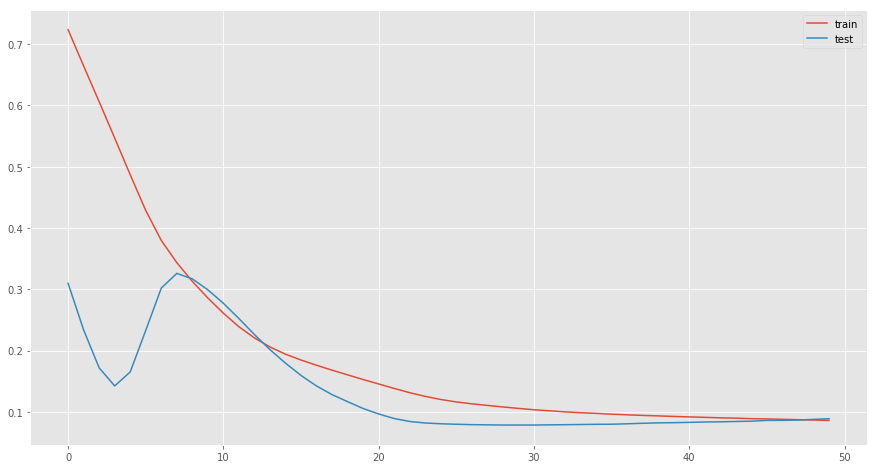

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.00035, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer= adam)
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Above is the plot of the loss function for our model.

## Forecast Plot for VIXCM30 and RMSE% of model.

### Forecast using the .predict() function on the test dataset.

In [0]:
# make a prediction
predicted = model.predict(test_X)
PRED1 = np.array(predicted)
PRED2 = PRED1.reshape(len(predicted),1)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X1[:, :-1],PRED2), axis=1)
Forecast = ((inv_yhat[:,-1])*sdVIX30)+muVIX30

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X1[:, :-1],test_y1), axis=1)
Actual = ((inv_y[:,-1])*sdVIX30)+muVIX30
# calculate RMSE
rmse = sqrt(mean_squared_error(Actual, Forecast))
avg = np.mean(Actual)
rmsep = rmse/avg
print('Test Root Mean Squared Error: %.3f' % rmse)
print('Test Root Mean Squared Error Percentage: %.3f' % rmsep)

Test Root Mean Squared Error: 1.011
Test Root Mean Squared Error Percentage: 0.057


We are choosing to use the basic predict function with the test data for our forecast. We considered and made a function to forecast the dependent variable based on our predicted values from the prior day of that variable. However we realized that we didn't create a model to predict the independent variables. So while we might be able to replace the values for the VIXCM30, for example in the test data, we still have to use the  values for the SPY, RealVol, and VIX. Ultimately this means our forecast is based on predicting one day at a time based on the test data we have for the prior day, and the model seems to do this very well.

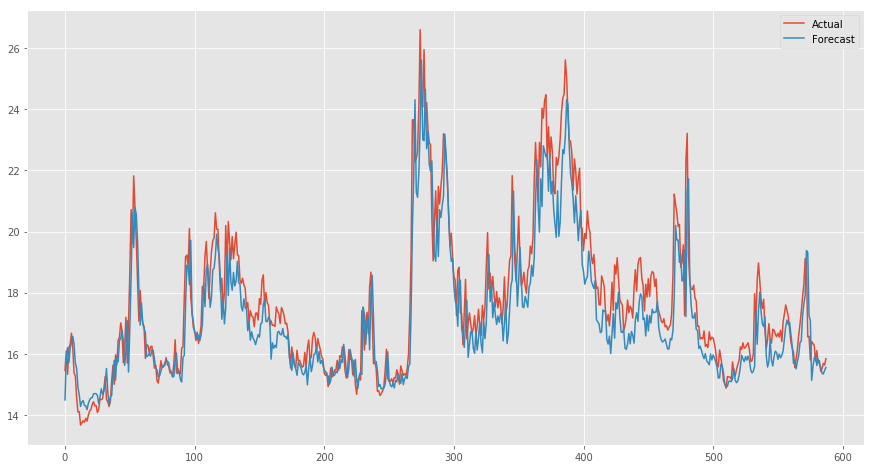

In [0]:
pyplot.plot(Actual, label = 'Actual')
pyplot.plot(Forecast, label = 'Forecast')
pyplot.legend()
pyplot.show()

---

## Repeat the Process to forecast VIXCM60, VIXCM90, VIXCM120, and VIXCM150

## VIXCM60 Forecast: Data Prep and Modeling

#### Select only variables to be used in forecasting VIXCM60

In [0]:
df1 = vix[['SPY','RealVol','VIX','VIXCM60']]

#### Split Training/Testing Data

In [0]:
train,test = train_test_split(df1, test_size=0.2, shuffle=False)

#### Create/Store average and standard deviation of VIXCM60 from training data. To be used to reverse normalization of testing data for prediction.

In [0]:
muVIX60 = train['VIXCM60'].mean()
print(muVIX60)
sdVIX60 = train['VIXCM60'].std()
print(sdVIX60)

22.163014954694106
7.522137062320393


In [0]:
train11, test11 = normalizer(train, test)

In [0]:
values = train11.values
values = values.astype('float32')
values1 = test11.values
values1 = test11.astype('float32')

# frame as supervised learning
reframed_train = series_to_supervised(values, 1, 1)
reframed_test = series_to_supervised(values1, 1, 1)
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[4,5,6]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4,5,6]], axis=1, inplace=True)
#print(reframed_train.head())

In [0]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### Define a LSTM RNN, compile, fit with training data, and validate on testing data.

Train on 2353 samples, validate on 588 samples
Epoch 1/35
 - 2s - loss: 0.7904 - val_loss: 0.3494
Epoch 2/35
 - 0s - loss: 0.7404 - val_loss: 0.2810
Epoch 3/35
 - 0s - loss: 0.6922 - val_loss: 0.2174
Epoch 4/35
 - 0s - loss: 0.6427 - val_loss: 0.1670
Epoch 5/35
 - 0s - loss: 0.5912 - val_loss: 0.1469
Epoch 6/35
 - 0s - loss: 0.5376 - val_loss: 0.1645
Epoch 7/35
 - 0s - loss: 0.4833 - val_loss: 0.2110
Epoch 8/35
 - 0s - loss: 0.4306 - val_loss: 0.2792
Epoch 9/35
 - 0s - loss: 0.3885 - val_loss: 0.3322
Epoch 10/35
 - 0s - loss: 0.3551 - val_loss: 0.3492
Epoch 11/35
 - 0s - loss: 0.3255 - val_loss: 0.3455
Epoch 12/35
 - 0s - loss: 0.2987 - val_loss: 0.3324
Epoch 13/35
 - 0s - loss: 0.2742 - val_loss: 0.3147
Epoch 14/35
 - 0s - loss: 0.2531 - val_loss: 0.2938
Epoch 15/35
 - 0s - loss: 0.2354 - val_loss: 0.2696
Epoch 16/35
 - 0s - loss: 0.2209 - val_loss: 0.2430
Epoch 17/35
 - 0s - loss: 0.2086 - val_loss: 0.2185
Epoch 18/35
 - 0s - loss: 0.1976 - val_loss: 0.1969
Epoch 19/35
 - 0s - loss: 

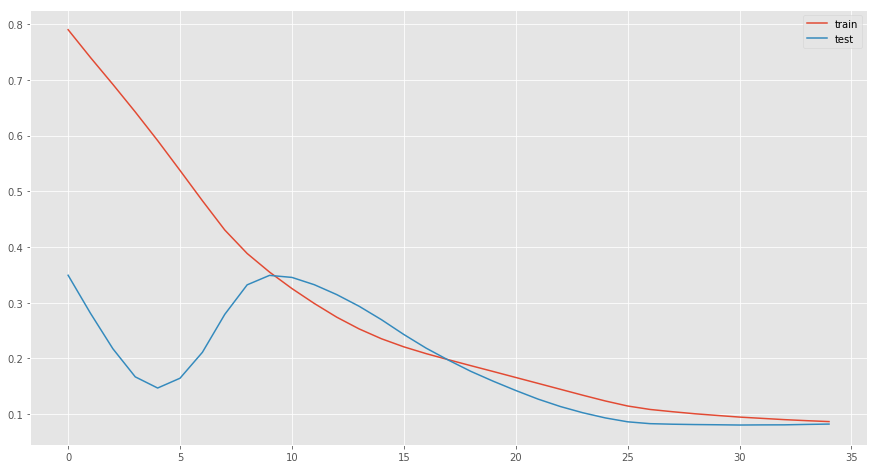

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.00035, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer= adam)
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Forecast Plot for VIXCM60 and RMSE% of model.

In [0]:
# make a prediction
predicted = model.predict(test_X)
PRED1 = np.array(predicted)
PRED2 = PRED1.reshape(len(predicted),1)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X1[:, :-1],PRED2), axis=1)
Forecast = ((inv_yhat[:,-1])*sdVIX60)+muVIX60

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X1[:, :-1],test_y1), axis=1)
Actual = ((inv_y[:,-1])*sdVIX60)+muVIX60
# calculate RMSE
rmse = sqrt(mean_squared_error(Actual, Forecast))
avg = np.mean(Actual)
rmsep = rmse/avg
print('Test Root Mean Squared Error: %.3f' % rmse)
print('Test Root Mean Squared Error Percentage: %.3f' % rmsep)

Test Root Mean Squared Error: 0.780
Test Root Mean Squared Error Percentage: 0.042


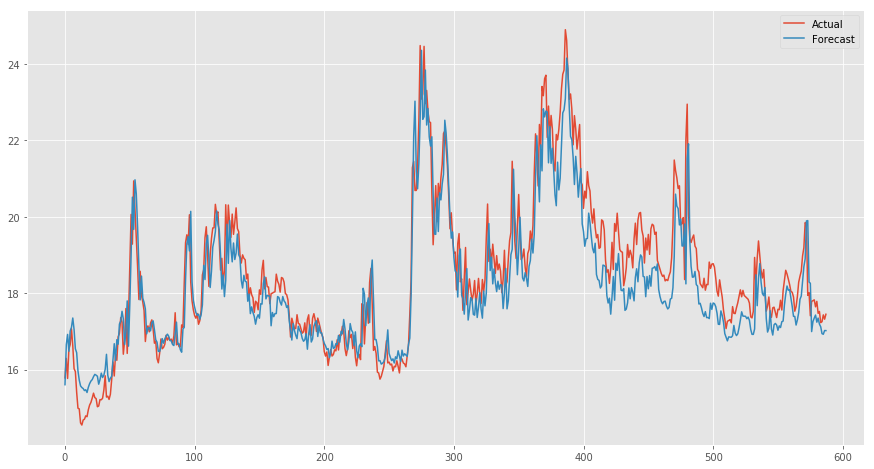

In [0]:
pyplot.plot(Actual, label = 'Actual')
pyplot.plot(Forecast, label = 'Forecast')
pyplot.legend()
pyplot.show()

---

## VIXCM90 Forecast: Data Prep and Modeling

#### Select only variables to be used in forecasting VIXCM60

In [0]:
df1 = vix[['SPY','RealVol','VIX','VIXCM90']]

#### Split Training/Testing Data

In [0]:
train,test = train_test_split(df1, test_size=0.2, shuffle=False)

#### Create/Store average and standard deviation of VIXCM90 from training data. To be used to reverse normalization of testing data for prediction.

In [0]:
muVIX90 = train['VIXCM90'].mean()
print(muVIX90)
sdVIX90 = train['VIXCM90'].std()
print(sdVIX90)

22.564956260186907
6.994630946052825


In [0]:
train11, test11 = normalizer(train, test)

In [0]:
values = train11.values
values = values.astype('float32')
values1 = test11.values
values1 = test11.astype('float32')

# frame as supervised learning
reframed_train = series_to_supervised(values, 1, 1)
reframed_test = series_to_supervised(values1, 1, 1)
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[4,5,6]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4,5,6]], axis=1, inplace=True)
#print(reframed_train.head())

In [0]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### Define a LSTM RNN, compile, fit with training data, and validate on testing data.

Train on 2353 samples, validate on 588 samples
Epoch 1/35
 - 2s - loss: 0.7490 - val_loss: 0.3816
Epoch 2/35
 - 0s - loss: 0.6975 - val_loss: 0.3043
Epoch 3/35
 - 0s - loss: 0.6479 - val_loss: 0.2317
Epoch 4/35
 - 0s - loss: 0.5974 - val_loss: 0.1703
Epoch 5/35
 - 0s - loss: 0.5459 - val_loss: 0.1373
Epoch 6/35
 - 0s - loss: 0.4933 - val_loss: 0.1422
Epoch 7/35
 - 0s - loss: 0.4416 - val_loss: 0.1787
Epoch 8/35
 - 0s - loss: 0.3947 - val_loss: 0.2354
Epoch 9/35
 - 0s - loss: 0.3579 - val_loss: 0.2763
Epoch 10/35
 - 0s - loss: 0.3273 - val_loss: 0.2870
Epoch 11/35
 - 0s - loss: 0.2999 - val_loss: 0.2813
Epoch 12/35
 - 0s - loss: 0.2744 - val_loss: 0.2679
Epoch 13/35
 - 0s - loss: 0.2520 - val_loss: 0.2482
Epoch 14/35
 - 0s - loss: 0.2328 - val_loss: 0.2242
Epoch 15/35
 - 0s - loss: 0.2162 - val_loss: 0.1980
Epoch 16/35
 - 0s - loss: 0.2023 - val_loss: 0.1748
Epoch 17/35
 - 0s - loss: 0.1893 - val_loss: 0.1532
Epoch 18/35
 - 0s - loss: 0.1764 - val_loss: 0.1349
Epoch 19/35
 - 0s - loss: 

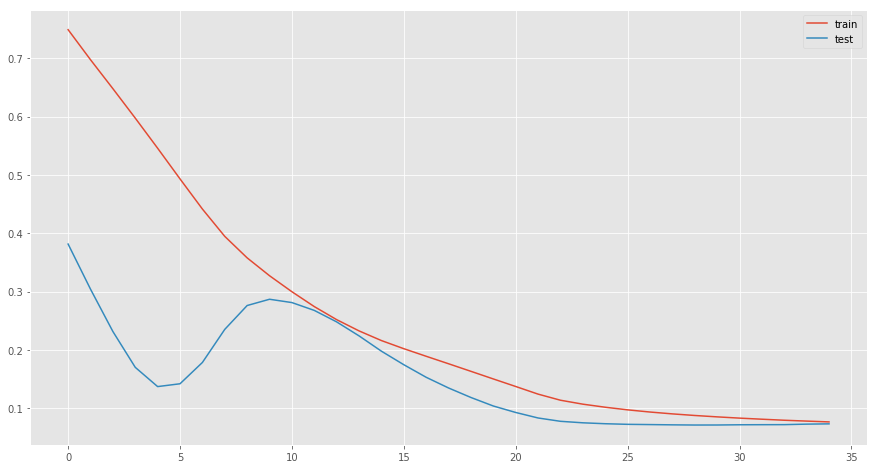

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.00035, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer= adam)
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Forecast Plot for VIXCM90 and RMSE% of model.

In [0]:
# make a prediction
predicted = model.predict(test_X)
PRED1 = np.array(predicted)
PRED2 = PRED1.reshape(len(predicted),1)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X1[:, :-1],PRED2), axis=1)
Forecast = ((inv_yhat[:,-1])*sdVIX90)+muVIX90

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X1[:, :-1],test_y1), axis=1)
Actual = ((inv_y[:,-1])*sdVIX90)+muVIX90
# calculate RMSE
rmse = sqrt(mean_squared_error(Actual, Forecast))
avg = np.mean(Actual)
rmsep = rmse/avg
print('Test Root Mean Squared Error: %.3f' % rmse)
print('Test Root Mean Squared Error Percentage: %.3f' % rmsep)

Test Root Mean Squared Error: 0.657
Test Root Mean Squared Error Percentage: 0.035


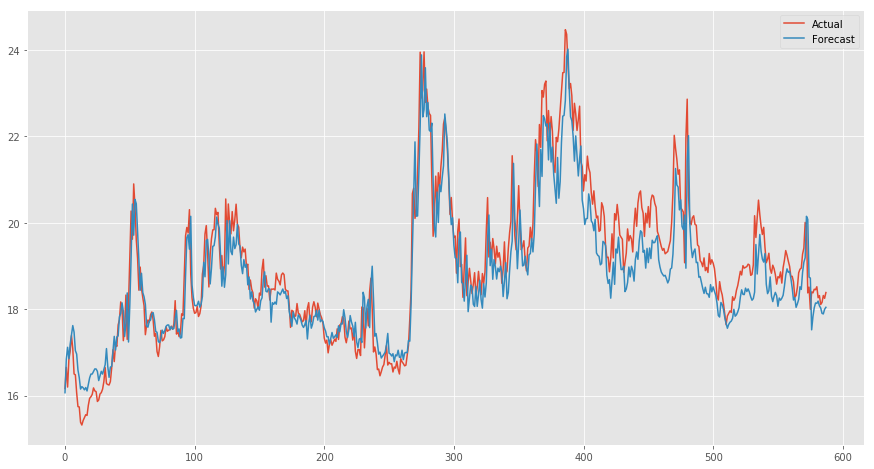

In [0]:
pyplot.plot(Actual, label = 'Actual')
pyplot.plot(Forecast, label = 'Forecast')
pyplot.legend()
pyplot.show()

---

## VIXCM120 Forecast: Data Prep and Modeling

#### Select only variables to be used in forecasting VIXCM60

In [0]:
df1 = vix[['SPY','RealVol','VIX','VIXCM120']]

#### Split Training/Testing Data

In [0]:
train,test = train_test_split(df1, test_size=0.2, shuffle=False)

#### Create/Store average and standard deviation of VIXCM120 from training data. To be used to reverse normalization of testing data for prediction.

In [0]:
muVIX120 = train['VIXCM120'].mean()
print(muVIX120)
sdVIX120 = train['VIXCM120'].std()
print(sdVIX120)

22.89975839888275
6.6677169915990335


In [0]:
train11, test11 = normalizer(train, test)

In [0]:
values = train11.values
values = values.astype('float32')
values1 = test11.values
values1 = test11.astype('float32')

# frame as supervised learning
reframed_train = series_to_supervised(values, 1, 1)
reframed_test = series_to_supervised(values1, 1, 1)
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[4,5,6]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4,5,6]], axis=1, inplace=True)
#print(reframed_train.head())

In [0]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### Define a LSTM RNN, compile, fit with training data, and validate on testing data.

Train on 2353 samples, validate on 588 samples
Epoch 1/35
 - 3s - loss: 0.7542 - val_loss: 0.3205
Epoch 2/35
 - 0s - loss: 0.7044 - val_loss: 0.2443
Epoch 3/35
 - 0s - loss: 0.6559 - val_loss: 0.1778
Epoch 4/35
 - 0s - loss: 0.6054 - val_loss: 0.1423
Epoch 5/35
 - 0s - loss: 0.5531 - val_loss: 0.1459
Epoch 6/35
 - 0s - loss: 0.5004 - val_loss: 0.1821
Epoch 7/35
 - 0s - loss: 0.4506 - val_loss: 0.2493
Epoch 8/35
 - 0s - loss: 0.4100 - val_loss: 0.3080
Epoch 9/35
 - 0s - loss: 0.3762 - val_loss: 0.3275
Epoch 10/35
 - 0s - loss: 0.3457 - val_loss: 0.3255
Epoch 11/35
 - 0s - loss: 0.3171 - val_loss: 0.3129
Epoch 12/35
 - 0s - loss: 0.2903 - val_loss: 0.2927
Epoch 13/35
 - 0s - loss: 0.2665 - val_loss: 0.2672
Epoch 14/35
 - 0s - loss: 0.2458 - val_loss: 0.2376
Epoch 15/35
 - 0s - loss: 0.2278 - val_loss: 0.2061
Epoch 16/35
 - 0s - loss: 0.2108 - val_loss: 0.1767
Epoch 17/35
 - 0s - loss: 0.1941 - val_loss: 0.1515
Epoch 18/35
 - 0s - loss: 0.1776 - val_loss: 0.1297
Epoch 19/35
 - 0s - loss: 

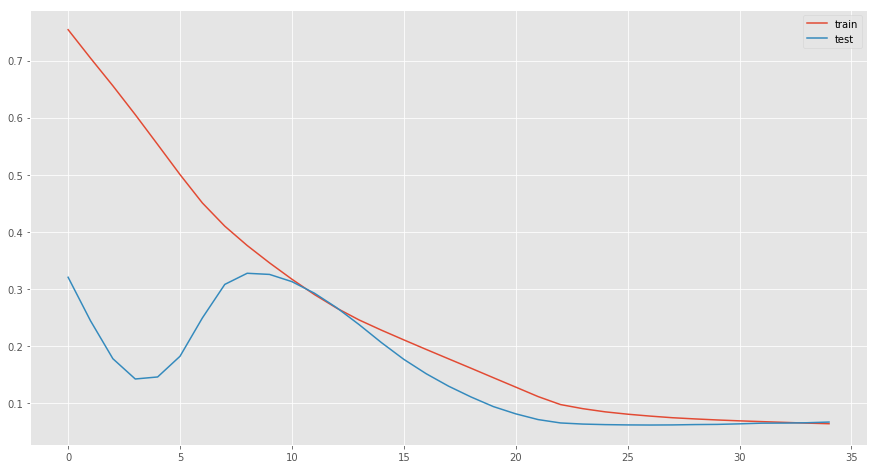

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.00035, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer= adam)
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Forecast Plot for VIXCM120 and RMSE% of model.

In [0]:
# make a prediction
predicted = model.predict(test_X)
PRED1 = np.array(predicted)
PRED2 = PRED1.reshape(len(predicted),1)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X1[:, :-1],PRED2), axis=1)
Forecast = ((inv_yhat[:,-1])*sdVIX120)+muVIX120

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X1[:, :-1],test_y1), axis=1)
Actual = ((inv_y[:,-1])*sdVIX120)+muVIX120
# calculate RMSE
rmse = sqrt(mean_squared_error(Actual, Forecast))
avg = np.mean(Actual)
rmsep = rmse/avg
print('Test Root Mean Squared Error: %.3f' % rmse)
print('Test Root Mean Squared Error Percentage: %.3f' % rmsep)

Test Root Mean Squared Error: 0.579
Test Root Mean Squared Error Percentage: 0.030


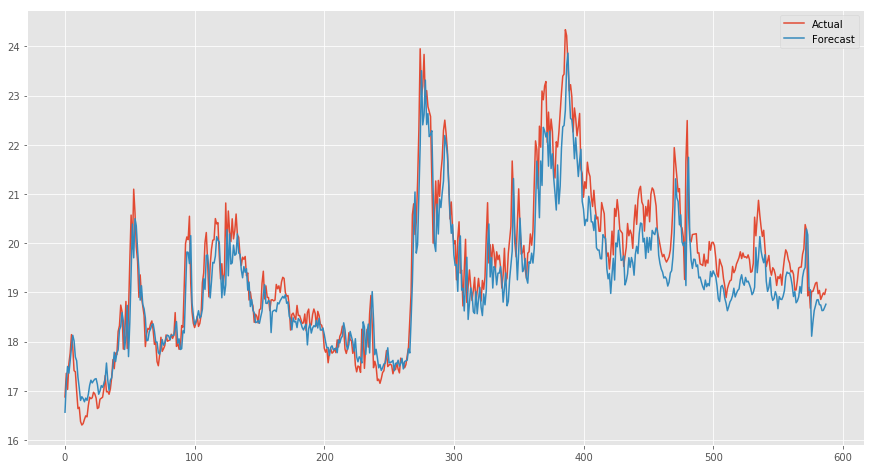

In [0]:
pyplot.plot(Actual, label = 'Actual')
pyplot.plot(Forecast, label = 'Forecast')
pyplot.legend()
pyplot.show()

---

## VIXCM150 Forecast: Data Prep and Modeling

#### Select only variables to be used in forecasting VIXCM60

In [0]:
df1 = vix[['SPY','RealVol','VIX','VIXCM150']]

#### Split Training/Testing Data

In [0]:
train,test = train_test_split(df1, test_size=0.2, shuffle=False)

#### Create/Store average and standard deviation of VIXCM150 from training data. To be used to reverse normalization of testing data for prediction.

In [0]:
muVIX150 = train['VIXCM150'].mean()
print(muVIX150)
sdVIX150 = train['VIXCM150'].std()
print(sdVIX150)

22.953431086035344
5.964760801860645


In [0]:
train11, test11 = normalizer(train, test)

In [0]:
values = train11.values
values = values.astype('float32')
values1 = test11.values
values1 = test11.astype('float32')

# frame as supervised learning
reframed_train = series_to_supervised(values, 1, 1)
reframed_test = series_to_supervised(values1, 1, 1)
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[4,5,6]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4,5,6]], axis=1, inplace=True)
#print(reframed_train.head())

In [0]:
# split into input and outputs
train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### Define a LSTM RNN, compile, fit with training data, and validate on testing data.

Train on 2353 samples, validate on 588 samples
Epoch 1/35
 - 3s - loss: 0.8331 - val_loss: 0.3421
Epoch 2/35
 - 0s - loss: 0.7627 - val_loss: 0.2508
Epoch 3/35
 - 0s - loss: 0.6948 - val_loss: 0.1857
Epoch 4/35
 - 0s - loss: 0.6255 - val_loss: 0.1818
Epoch 5/35
 - 0s - loss: 0.5555 - val_loss: 0.2008
Epoch 6/35
 - 0s - loss: 0.4872 - val_loss: 0.2461
Epoch 7/35
 - 0s - loss: 0.4307 - val_loss: 0.3179
Epoch 8/35
 - 0s - loss: 0.3918 - val_loss: 0.3383
Epoch 9/35
 - 0s - loss: 0.3582 - val_loss: 0.3255
Epoch 10/35
 - 0s - loss: 0.3265 - val_loss: 0.3017
Epoch 11/35
 - 0s - loss: 0.2951 - val_loss: 0.2741
Epoch 12/35
 - 0s - loss: 0.2642 - val_loss: 0.2453
Epoch 13/35
 - 0s - loss: 0.2340 - val_loss: 0.2159
Epoch 14/35
 - 0s - loss: 0.2044 - val_loss: 0.1887
Epoch 15/35
 - 0s - loss: 0.1753 - val_loss: 0.1632
Epoch 16/35
 - 0s - loss: 0.1467 - val_loss: 0.1353
Epoch 17/35
 - 0s - loss: 0.1195 - val_loss: 0.1112
Epoch 18/35
 - 0s - loss: 0.0955 - val_loss: 0.0953
Epoch 19/35
 - 0s - loss: 

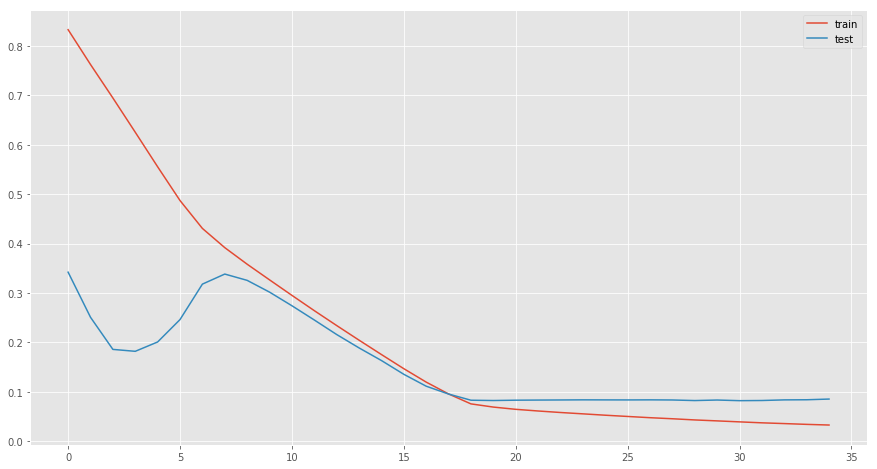

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.00045, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer= adam)
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Forecast Plot for VIXCM150 and RMSE% of model.

In [0]:
# make a prediction
predicted = model.predict(test_X)
PRED1 = np.array(predicted)
PRED2 = PRED1.reshape(len(predicted),1)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X1[:, :-1],PRED2), axis=1)
Forecast = ((inv_yhat[:,-1])*sdVIX150)+muVIX150

# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X1[:, :-1],test_y1), axis=1)
Actual = ((inv_y[:,-1])*sdVIX150)+muVIX150
# calculate RMSE
rmse = sqrt(mean_squared_error(Actual, Forecast))
avg = np.mean(Actual)
rmsep = rmse/avg
print('Test Root Mean Squared Error: %.3f' % rmse)
print('Test Root Mean Squared Error Percentage: %.3f' % rmsep)

Test Root Mean Squared Error: 0.614
Test Root Mean Squared Error Percentage: 0.030


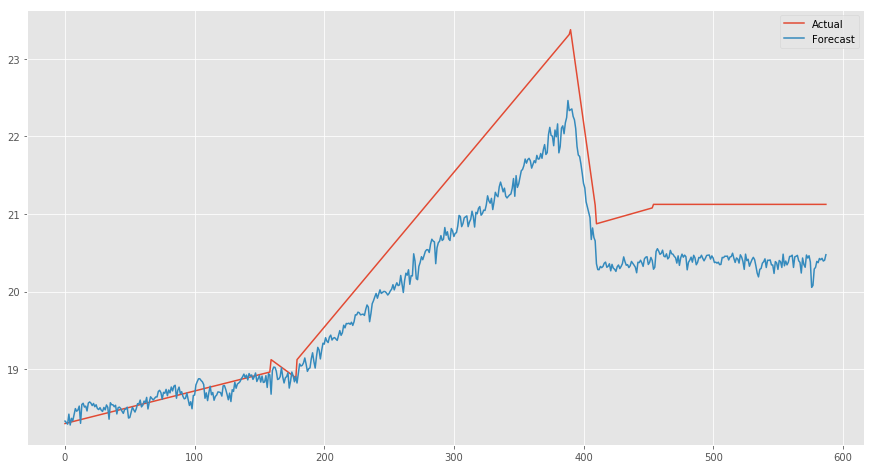

In [0]:
pyplot.plot(Actual, label = 'Actual')
pyplot.plot(Forecast, label = 'Forecast')
pyplot.legend()
pyplot.show()

---

# Compare Models 1-Day Forecast

| Model                               |RMSEP (VIXCM30)|RMSEP (VIXCM60)|RMSEP (VIXCM90)|RMSEP (VIXCM120)|RMSEP (VIXCM150)| 
| ------------------------------------|:-------------:|:-------------:|:-------------:|:--------------:|:--------------:| 
| LSTM                                | 0.0570        | 0.0420        | 0.0350        | 0.0300         | 0.0300         | 
| VECM model (order = 113)            | 0.0545        | 0.0387        | 0.0314        | 0.0273         | 0.0035         |  
| Naive model                         | 0.1841        | 0.1717        | 0.1691        | 0.1709         | 0.1698         |


Using the Naive model as our baseline, we look to minimize the root mean squared error percentage to determine our best model. In this case we found that the VECM model used to be the best model to predict the VIXCM30, VIXCM60, VIXCM90, VIXCM120, and VIXCM150.

# Results and Limitation
1. 1- Day forecast models are accurate to the value
2. Multi-day forecast models provide accurate trends not values through the first 200 forecasted days
3. VECM model and RNN model performs better than Naive model
4. More complex LSTM model might yield better results
5. Interpolation is a useful way to handle sporadic null values such as VIXCM120 but not a useful way to handle consecutive      missing values such as VIXCM150